# Chapter 1. Data Cleaning

https://www.kaggle.com/datasets/danielgrijalvas/movies/data

We think one avenue we can go is to use consumer price index for the US (per year) to predict the gross revenue of a movie




In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ast
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from datetime import datetime
from dateutil import parser
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU, LSTM, Embedding
from keras.optimizers import Adam

In [ ]:
cpi = pd.read_csv('https://pkgstore.datahub.io/core/cpi/cpi_csv/data/04cb8fe18892497287d23e20d0e1ceb9/cpi_csv.csv')
cpi = cpi.drop(columns = 'Country Code')
cpi = cpi.loc[cpi['Year'] >= 1986]
cpi = cpi.loc[cpi['Country Name'] == 'United States']
cpi = cpi.drop(columns = 'Country Name')
cpi = cpi.set_index('Year')
cpi.head()

,CPI
Year,
1986,50.262433
1987,52.142688
1988,54.233135
1989,56.850970
1990,59.919760


## Three decades of movie data (1986-2014), scraped from IMDb using Python. (220 movies per year, 1986-2014)

In [ ]:
movies = pd.read_csv('movies 2.csv')
movies = movies.loc[movies['year'] <= 2014]
movies = movies.loc[movies['country'] == 'United States']

movies = movies.rename(columns={'year': 'Year'})
movies

,name,rating,genre,Year,released,score,votes,director,writer,star,country,budget,gross,company,runtime
1,The Blue Lagoon,R,Adventure,1980,"July 2, 1980 (United States)",5.8,65000.0,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,United States,4500000.0,58853106.0,Columbia Pictures,104.0
2,Star Wars: Episode V - The Empire Strikes Back,PG,Action,1980,"June 20, 1980 (United States)",8.7,1200000.0,Irvin Kershner,Leigh Brackett,Mark Hamill,United States,18000000.0,538375067.0,Lucasfilm,124.0
3,Airplane!,PG,Comedy,1980,"July 2, 1980 (United States)",7.7,221000.0,Jim Abrahams,Jim Abrahams,Robert Hays,United States,3500000.0,83453539.0,Paramount Pictures,88.0
4,Caddyshack,R,Comedy,1980,"July 25, 1980 (United States)",7.3,108000.0,Harold Ramis,Brian Doyle-Murray,Chevy Chase,United States,6000000.0,39846344.0,Orion Pictures,98.0
5,Friday the 13th,R,Horror,1980,"May 9, 1980 (United States)",6.4,123000.0,Sean S. Cunningham,Victor Miller,Betsy Palmer,United States,550000.0,39754601.0,Paramount Pictures,95.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6637,Top Five,R,Comedy,2014,"December 12, 2014 (United States)",6.4,26000.0,Chris Rock,Chris Rock,Chris Rock,United States,12000000.0,26117471.0,IAC Films,102.0
6638,99 Homes,R,Drama,2014,"October 9, 2015 (United States)",7.1,32000.0,Ramin Bahrani,Ramin Bahrani,Andrew Garfield,United States,8000000.0,1828232.0,Broad Green Pictures,112.0
6639,Black or White,PG-13,Drama,2014,"January 30, 2015 (United States)",6.6,12000.0,Mike Binder,Mike Binder,Kevin Costner,United States,9000000.0,21833967.0,BlackWhite,121.0
6641,Big Stone Gap,PG-13,Comedy,2014,"May 20, 2016 (Spain)",5.7,2800.0,Adriana Trigiani,Adriana Trigiani,Ashley Judd,United States,NaN,1012804.0,Altar Identity Studios,103.0


In [ ]:
# combining the CPI and movie datasets
merged_df = pd.merge(movies, cpi, on='Year')

In [ ]:
nan_values = merged_df.isna().sum()
print(nan_values)

name          0
rating        5
genre         0
Year          0
released      0
score         0
votes         0
director      0
writer        0
star          0
country       0
budget      741
gross        43
company       6
runtime       1
CPI           0
dtype: int64


## this section drops NAN values

In [ ]:
merged_df['success'] = (merged_df['gross'] / merged_df['budget']).apply(lambda x: 1 if x > 2 else 0)
merged_df_copy = merged_df.copy() # for imputing budget for CART

merged_df = merged_df.dropna(subset=['budget'])
nan_count = merged_df['score'].isna().sum()

merged_df.head()

,name,rating,genre,Year,released,score,votes,director,writer,star,country,budget,gross,company,runtime,CPI,success
0,Top Gun,PG,Action,1986,"May 16, 1986 (United States)",6.9,306000.0,Tony Scott,Jim Cash,Tom Cruise,United States,15000000.0,357288178.0,Paramount Pictures,110.0,50.262433,1
1,Stand by Me,R,Adventure,1986,"August 22, 1986 (United States)",8.1,374000.0,Rob Reiner,Stephen King,Wil Wheaton,United States,8000000.0,52287414.0,Columbia Pictures,89.0,50.262433,1
2,Ferris Bueller's Day Off,PG-13,Comedy,1986,"June 11, 1986 (United States)",7.8,330000.0,John Hughes,John Hughes,Matthew Broderick,United States,6000000.0,70720215.0,Paramount Pictures,103.0,50.262433,1
3,Big Trouble in Little China,PG-13,Action,1986,"July 2, 1986 (United States)",7.3,128000.0,John Carpenter,Gary Goldman,Kurt Russell,United States,25000000.0,11100577.0,Twentieth Century Fox,99.0,50.262433,0
4,Pretty in Pink,PG-13,Comedy,1986,"February 28, 1986 (United States)",6.8,76000.0,Howard Deutch,John Hughes,Molly Ringwald,United States,9000000.0,40479480.0,Paramount Pictures,97.0,50.262433,1


In [ ]:
nan_values = merged_df.isna().sum()
print(nan_values)

name         0
rating       4
genre        0
Year         0
released     0
score        0
votes        0
director     0
writer       0
star         0
country      0
budget       0
gross       23
company      1
runtime      1
CPI          0
success      0
dtype: int64


## Cleaning Steps + One-hot encoding + Creating More Measureable Variables

In [ ]:
# Converting 'budget' to numeric
merged_df['budget'] = pd.to_numeric(merged_df['budget'], errors='coerce')

# Previewing the cleaned dataset
merged_df.head()

,name,rating,genre,Year,released,score,votes,director,writer,star,country,budget,gross,company,runtime,CPI,success
0,Top Gun,PG,Action,1986,"May 16, 1986 (United States)",6.9,306000.0,Tony Scott,Jim Cash,Tom Cruise,United States,15000000.0,357288178.0,Paramount Pictures,110.0,50.262433,1
1,Stand by Me,R,Adventure,1986,"August 22, 1986 (United States)",8.1,374000.0,Rob Reiner,Stephen King,Wil Wheaton,United States,8000000.0,52287414.0,Columbia Pictures,89.0,50.262433,1
2,Ferris Bueller's Day Off,PG-13,Comedy,1986,"June 11, 1986 (United States)",7.8,330000.0,John Hughes,John Hughes,Matthew Broderick,United States,6000000.0,70720215.0,Paramount Pictures,103.0,50.262433,1
3,Big Trouble in Little China,PG-13,Action,1986,"July 2, 1986 (United States)",7.3,128000.0,John Carpenter,Gary Goldman,Kurt Russell,United States,25000000.0,11100577.0,Twentieth Century Fox,99.0,50.262433,0
4,Pretty in Pink,PG-13,Comedy,1986,"February 28, 1986 (United States)",6.8,76000.0,Howard Deutch,John Hughes,Molly Ringwald,United States,9000000.0,40479480.0,Paramount Pictures,97.0,50.262433,1


In [ ]:
nan_values = merged_df.isna().sum()
print(nan_values)

name         0
rating       4
genre        0
Year         0
released     0
score        0
votes        0
director     0
writer       0
star         0
country      0
budget       0
gross       23
company      1
runtime      1
CPI          0
success      0
dtype: int64


In [ ]:
from dateutil import parser

merged_df['released'] = merged_df['released'].astype(str).apply(lambda x: parser.parse(x, fuzzy=True))

merged_df['year'] = merged_df['released'].dt.year
merged_df['month'] = merged_df['released'].dt.month
merged_df['day'] = merged_df['released'].dt.day

merged_df.head()

,name,rating,genre,Year,released,score,votes,director,writer,star,country,budget,gross,company,runtime,CPI,success,year,month,day
0,Top Gun,PG,Action,1986,1986-05-16,6.9,306000.0,Tony Scott,Jim Cash,Tom Cruise,United States,15000000.0,357288178.0,Paramount Pictures,110.0,50.262433,1,1986,5,16
1,Stand by Me,R,Adventure,1986,1986-08-22,8.1,374000.0,Rob Reiner,Stephen King,Wil Wheaton,United States,8000000.0,52287414.0,Columbia Pictures,89.0,50.262433,1,1986,8,22
2,Ferris Bueller's Day Off,PG-13,Comedy,1986,1986-06-11,7.8,330000.0,John Hughes,John Hughes,Matthew Broderick,United States,6000000.0,70720215.0,Paramount Pictures,103.0,50.262433,1,1986,6,11
3,Big Trouble in Little China,PG-13,Action,1986,1986-07-02,7.3,128000.0,John Carpenter,Gary Goldman,Kurt Russell,United States,25000000.0,11100577.0,Twentieth Century Fox,99.0,50.262433,0,1986,7,2
4,Pretty in Pink,PG-13,Comedy,1986,1986-02-28,6.8,76000.0,Howard Deutch,John Hughes,Molly Ringwald,United States,9000000.0,40479480.0,Paramount Pictures,97.0,50.262433,1,1986,2,28


In [ ]:
nan_values = merged_df.isna().sum()
print(nan_values)

name         0
rating       4
genre        0
Year         0
released     0
score        0
votes        0
director     0
writer       0
star         0
country      0
budget       0
gross       23
company      1
runtime      1
CPI          0
success      0
year         0
month        0
day          0
dtype: int64


In [ ]:
merged_df.dropna(inplace=True)
nan_values = merged_df.isna().sum()
print(nan_values)

name        0
rating      0
genre       0
Year        0
released    0
score       0
votes       0
director    0
writer      0
star        0
country     0
budget      0
gross       0
company     0
runtime     0
CPI         0
success     0
year        0
month       0
day         0
dtype: int64


In [ ]:
# converting day of the week
from datetime import datetime
merged_df['released'] = pd.to_datetime(merged_df['released'])

def get_day_of_week(date):
    return date.strftime('%A')

merged_df['dayofweek'] = merged_df['released'].apply(get_day_of_week)

print(merged_df['dayofweek'])

0          Friday
1          Friday
2       Wednesday
3       Wednesday
4          Friday
          ...    
4212       Friday
4213       Friday
4214       Friday
4215       Friday
4217       Friday
Name: dayofweek, Length: 3448, dtype: object


In [ ]:
# create variables which measures who the top stars, companies, etc are

top_stars = merged_df['star'].value_counts().head(100)
merged_df['star_studded'] = 0
merged_df.loc[merged_df['star'].isin(top_stars.index), 'star_studded'] = 1

top_company = merged_df['company'].value_counts().head(20)
merged_df['top_company'] = 0
merged_df.loc[merged_df['company'].isin(top_company.index), 'top_company'] = 1

top_director = merged_df['director'].value_counts().head(20)
merged_df['top_director'] = 0
merged_df.loc[merged_df['director'].isin(top_company.index), 'top_director'] = 1

top_writer = merged_df['writer'].value_counts().head(20)
merged_df['top_writer'] = 0
merged_df.loc[merged_df['writer'].isin(top_company.index), 'top_writer'] = 1

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
merged_df['rating'] = label_encoder.fit_transform(merged_df['rating'])
merged_df['genre'] = label_encoder.fit_transform(merged_df['genre'])
merged_df['company'] = label_encoder.fit_transform(merged_df['company'])
merged_df['dayofweek'] = label_encoder.fit_transform(merged_df['dayofweek'])
merged_df['star'] = label_encoder.fit_transform(merged_df['star'])
merged_df['director'] = label_encoder.fit_transform(merged_df['director'])
merged_df['writer'] = label_encoder.fit_transform(merged_df['writer'])

merged_df

,name,rating,genre,Year,released,score,votes,director,writer,star,...,CPI,success,year,month,day,dayofweek,star_studded,top_company,top_director,top_writer
0,Top Gun,3,0,1986,1986-05-16,6.9,306000.0,1395,945,1155,...,50.262433,1,1986,5,16,0,1,1,0,0
1,Stand by Me,5,1,1986,1986-08-22,8.1,374000.0,1145,1955,1208,...,50.262433,1,1986,8,22,0,0,1,0,0
2,Ferris Bueller's Day Off,4,4,1986,1986-06-11,7.8,330000.0,665,1015,800,...,50.262433,1,1986,6,11,6,1,1,0,0
3,Big Trouble in Little China,4,0,1986,1986-07-02,7.3,128000.0,646,679,727,...,50.262433,0,1986,7,2,6,1,1,0,0
4,Pretty in Pink,4,4,1986,1986-02-28,6.8,76000.0,510,1015,865,...,50.262433,1,1986,2,28,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4212,Planes: Fire & Rescue,3,2,2014,2014-07-18,6.0,17000.0,1174,1799,256,...,108.566932,1,2014,7,18,0,0,0,0,0
4213,Top Five,5,4,2014,2014-12-12,6.4,26000.0,202,305,203,...,108.566932,1,2014,12,12,0,0,0,0,0
4214,99 Homes,5,6,2014,2015-10-09,7.1,32000.0,1097,1680,50,...,108.566932,0,2015,10,9,0,0,0,0,0
4215,Black or White,4,6,2014,2015-01-30,6.6,12000.0,943,1469,705,...,108.566932,1,2015,1,30,0,1,0,0,0


In [ ]:
all_columns = merged_df.columns.tolist()
all_columns
# columns we should include in all models when starting should include rating, genre, score, votes, CPI, budget, runtime, CPI, year, month, day, dayofweek, star_studded, top_company, top_director, top_writer

['name',
 'rating',
 'genre',
 'Year',
 'released',
 'score',
 'votes',
 'director',
 'writer',
 'star',
 'country',
 'budget',
 'gross',
 'company',
 'runtime',
 'CPI',
 'success',
 'year',
 'month',
 'day',
 'dayofweek',
 'star_studded',
 'top_company',
 'top_director',
 'top_writer']

# Chapter 2. EDA

# EDA

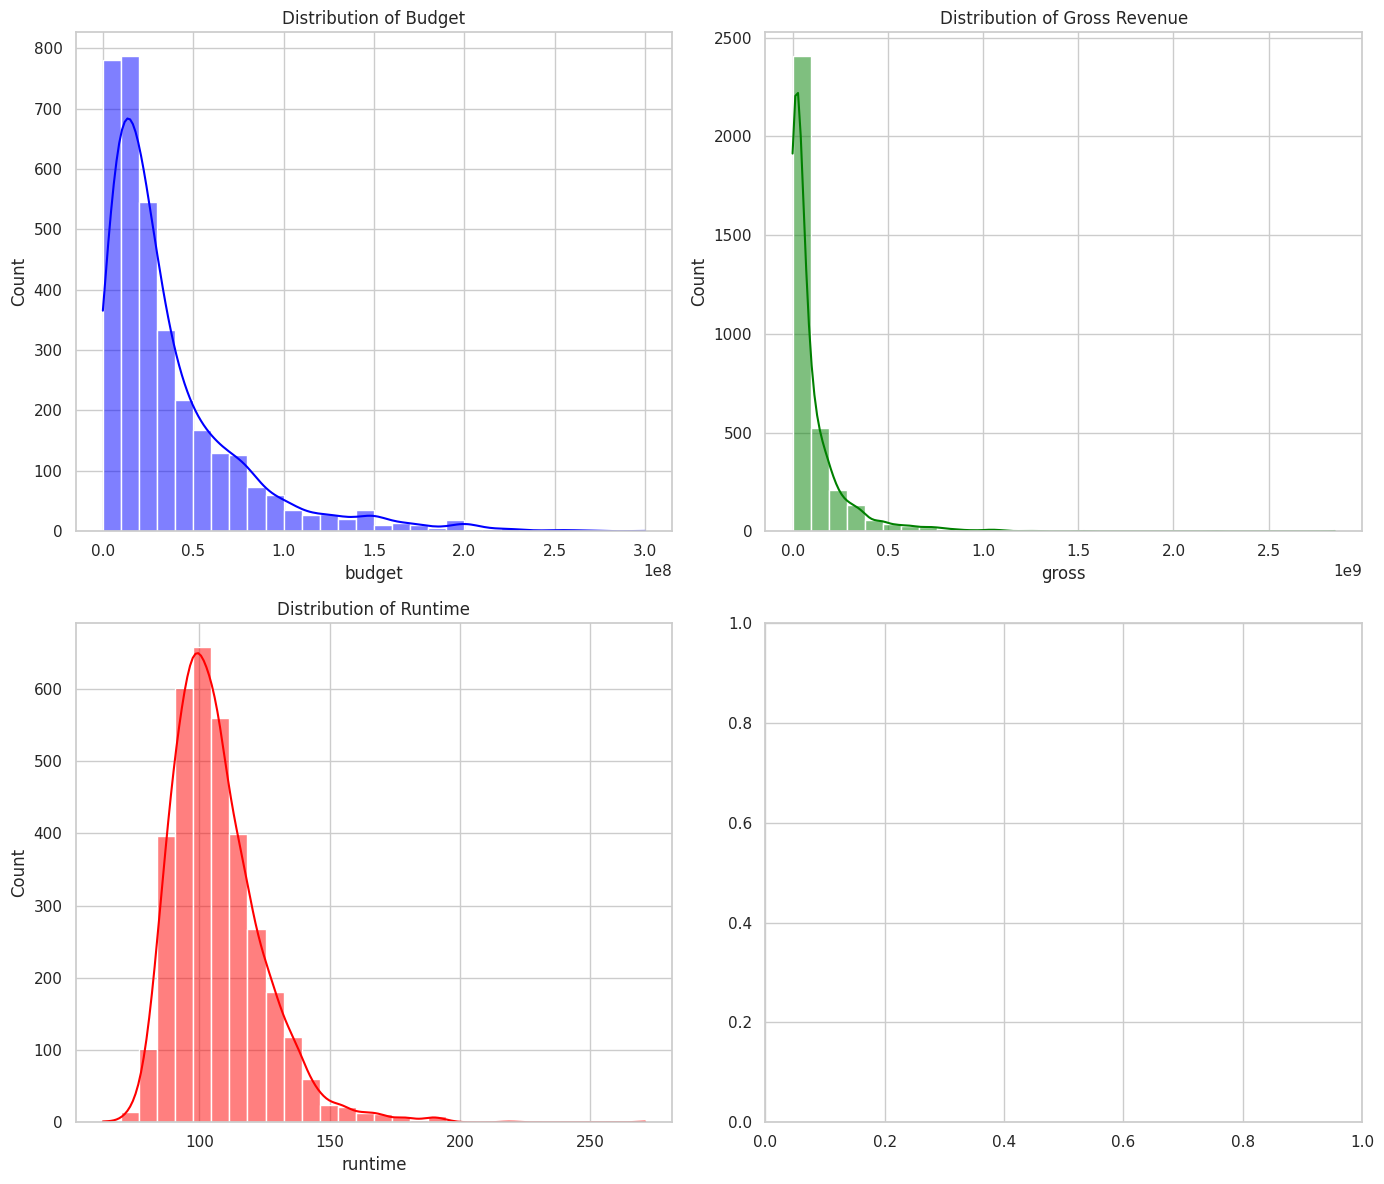

In [ ]:
import ast
import matplotlib.pyplot as plt
import seaborn as sns

# Setting the style of seaborn
sns.set(style="whitegrid")

# 1. Distribution of Numerical Features
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 12))
sns.histplot(data=merged_df, x='budget', bins=30, ax=axes[0, 0], kde=True, color='blue')
axes[0, 0].set_title('Distribution of Budget')
sns.histplot(data=merged_df, x='gross', bins=30, ax=axes[0, 1], kde=True, color='green')
axes[0, 1].set_title('Distribution of Gross Revenue')
sns.histplot(data=merged_df, x='runtime', bins=30, ax=axes[1, 0], kde=True, color='red')
axes[1, 0].set_title('Distribution of Runtime')
plt.tight_layout()
plt.show()


The histograms above provide insights into the distribution of budget, revenue, runtime, and number of production companies:

Budget: Most movies have a budget less than 100 million, with a peak at lower budgets.

Revenue: A similar trend is observed in revenue, with most movies earning less than 100 million.

Runtime: The majority of movies have a runtime around 90 to 120 minutes.

In [ ]:
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot, plot

#init_notebook_mode(connected=True)

# Define the order of genres
genre_order = ['Action', 'Adventure', 'Comedy', 'Drama', 'Crime', 'Horror', 'Biography',
               'Animation', 'Sci-Fi', 'Family', 'Fantasy', 'Thriller', 'Mystery', 'Romance']

fig = px.scatter(merged_df, x='budget', y='gross', hover_data=['name'], color='genre',
                 category_orders={'genre': genre_order},
                 width=900, height=900)

fig.update_layout(
    title='The Relationship between Budget and Revenue',
    xaxis_title='Budget',
    yaxis_title='Revenue',
    font=dict(size=12)
)

iplot(fig)


In [ ]:
correlation_matrix = merged_df.corr()

<ipython-input-19-99f056bbc563>:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



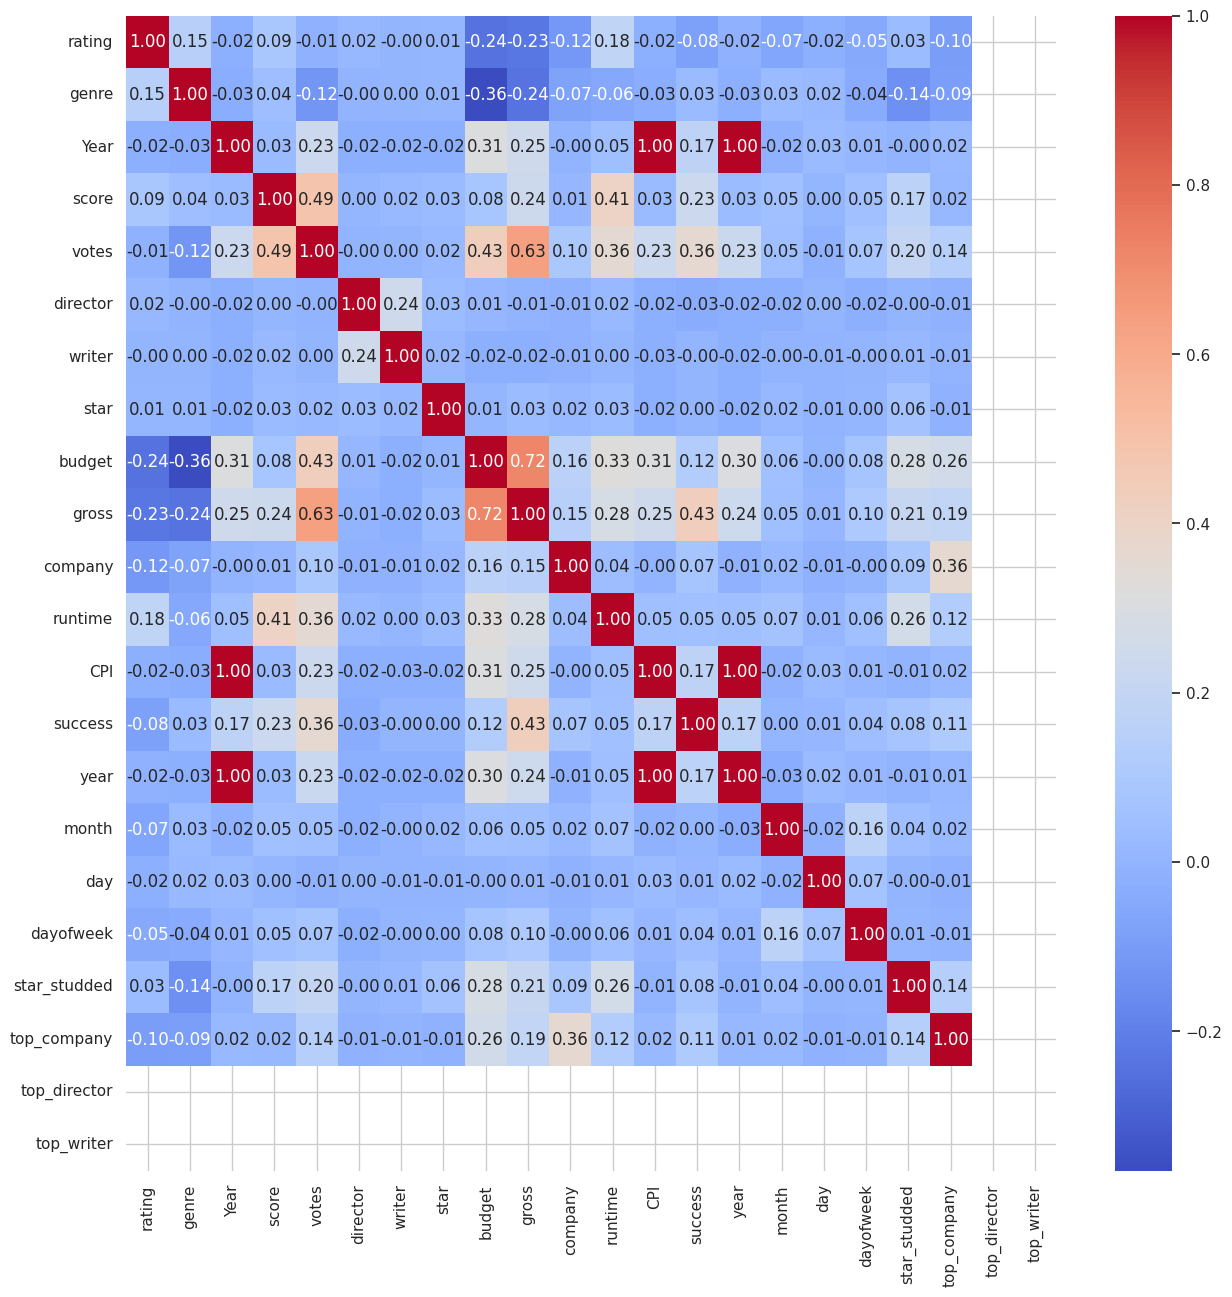

In [ ]:
plt.figure(figsize=(15,15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

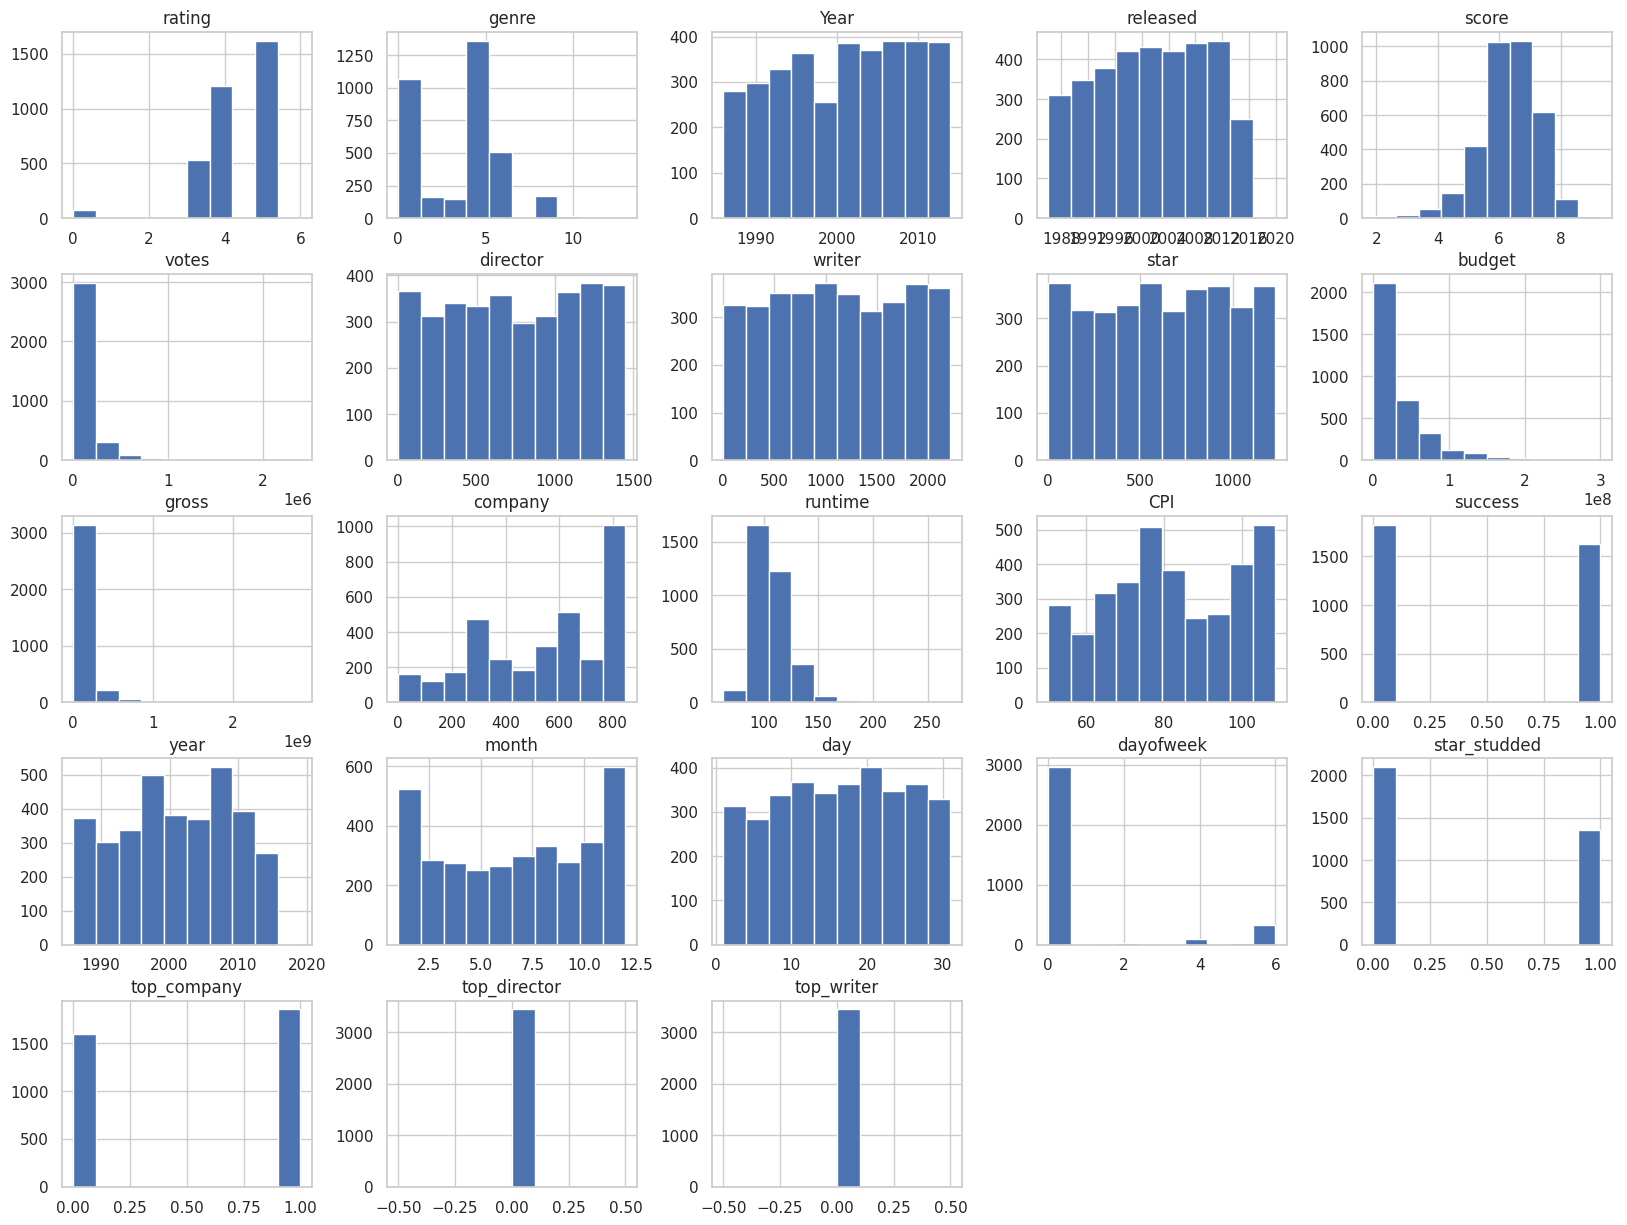

In [ ]:
merged_df.hist(figsize=(20,15))
plt.show()

# Chapter 3. Building Models and Feature Importance Determination

# Time Series

In [ ]:
time_series_df=merged_df.copy()
time_series_df=time_series_df[['released','gross']]
time_series_df['released'] = pd.to_datetime(time_series_df['released'])
time_series_df = time_series_df.sort_values(by='released')
time_series_df['year'] = time_series_df['released'].dt.year
avg_gross_per_year = time_series_df.groupby('year')['gross'].mean()
avg_gross_per_year_df = avg_gross_per_year.reset_index()
avg_gross_per_year_df.columns = ['year', 'avg_gross']

In [ ]:
year = avg_gross_per_year_df['year']

print(year.unique())

[1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999
 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013
 2014 2015 2016 2019]


In [ ]:
def plot_entire_series(x, y, tittle='',**kwargs):

    plt.figure(figsize=(16, 4))
    plt.plot(x, y, linewidth=2, color='black')
    for key, value in kwargs.items():
        plt.plot(x, value, linewidth=2, color=key)
    plt.xlabel('Date', fontsize=16)
    plt.ylabel('Sales', fontsize=16)
    plt.title(tittle)
    plt.show()
    return None
def plot_last_fifty(x, y, **kwargs):

    plt.figure(figsize=(16, 4))
    plt.scatter(x[-50:], y[-50:], linewidth=3, color='black')
    plt.plot(x[-50:], y[-50:], linewidth=3, color='black')

    for key, value in kwargs.items():
        plt.plot(x[-50:], value[-50:], linewidth=3, color=key)

    plt.xlabel('Date', fontsize=16)
    plt.ylabel('Sales', fontsize=16)
    plt.show()

    return None
def OSR2(model, X_test, y_test, y_train):
    y_pred = model.predict(X_test)
    SSE = np.sum((y_test - y_pred)**2)
    SST = np.sum((y_test - np.mean(y_train))**2)
    return (1 - SSE/SST)

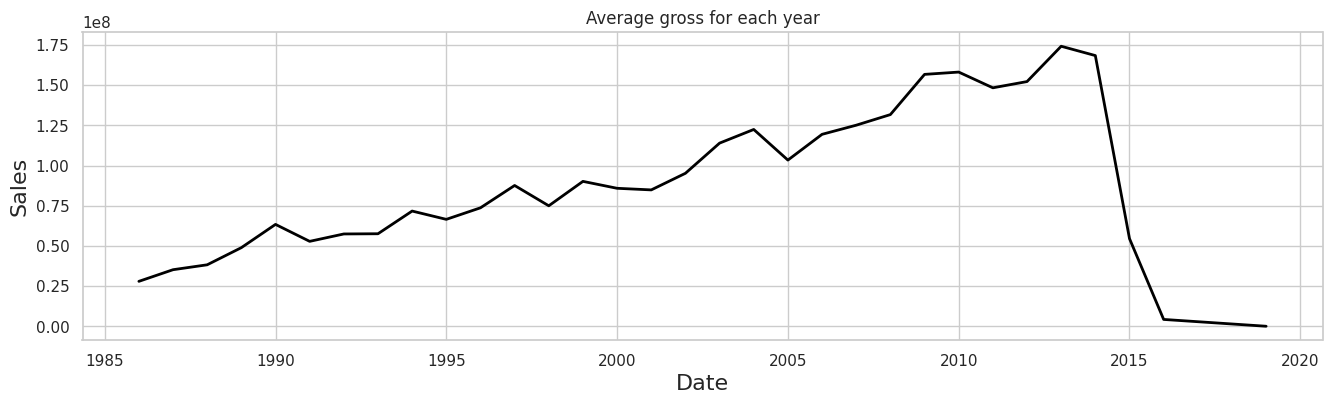

In [ ]:
plot_entire_series(avg_gross_per_year_df['year'],avg_gross_per_year_df['avg_gross'],'Average gross for each year')


In [ ]:
time_train = avg_gross_per_year_df[avg_gross_per_year_df['year'] < 2010]
time_test  = avg_gross_per_year_df[avg_gross_per_year_df['year'] >= 2010]
time_train['AvgGrossLastYear'] = time_train['avg_gross'].shift(1)
time_test['AvgGrossLastYear'] = time_test['avg_gross'].shift(1)
x = time_train['year'].to_numpy()
y = time_train['avg_gross'].to_numpy()
print(time_train.shape,time_test.shape)

(24, 3) (8, 3)


<ipython-input-26-d353fb035bbb>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-26-d353fb035bbb>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



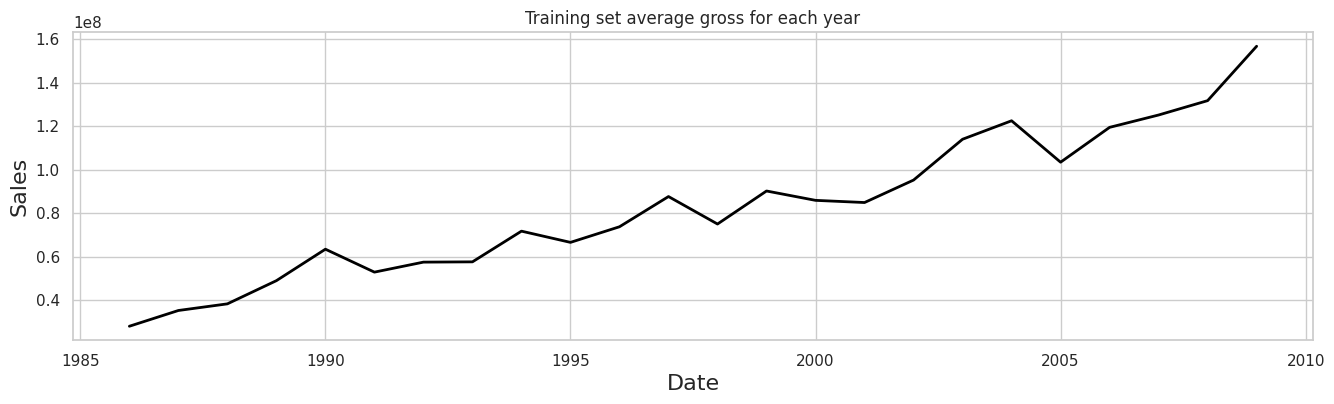

In [ ]:
plot_entire_series(x,y,'Training set average gross for each year')

# Auto-Regressive Model

In [ ]:
ar1 = smf.ols(formula='avg_gross ~ AvgGrossLastYear', data=time_train).fit()
print(ar1.summary())

                            OLS Regression Results                            
Dep. Variable:              avg_gross   R-squared:                       0.888
Model:                            OLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                     166.3
Date:                Sat, 09 Dec 2023   Prob (F-statistic):           1.91e-11
Time:                        04:48:41   Log-Likelihood:                -404.44
No. Observations:                  23   AIC:                             812.9
Df Residuals:                      21   BIC:                             815.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         5.478e+06   6.59e+06  

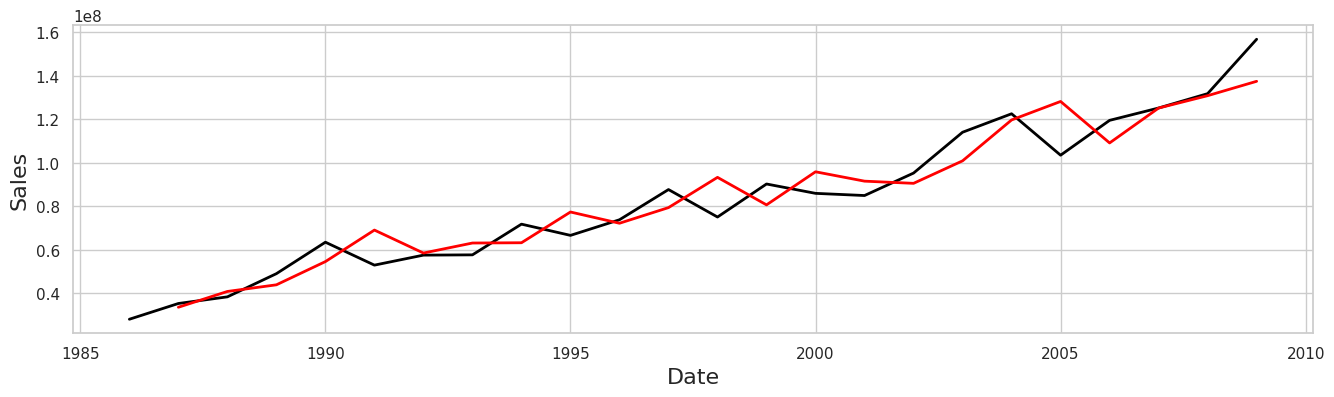

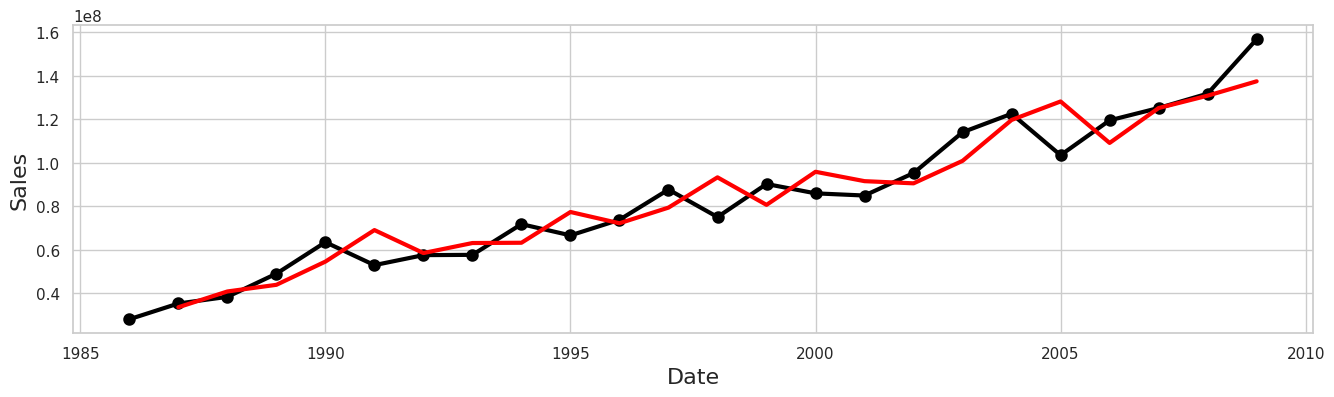

In [ ]:
y_pred = ar1.predict(time_train)
plot_entire_series(x, y, red=y_pred)
plot_last_fifty(x, y, red=y_pred)

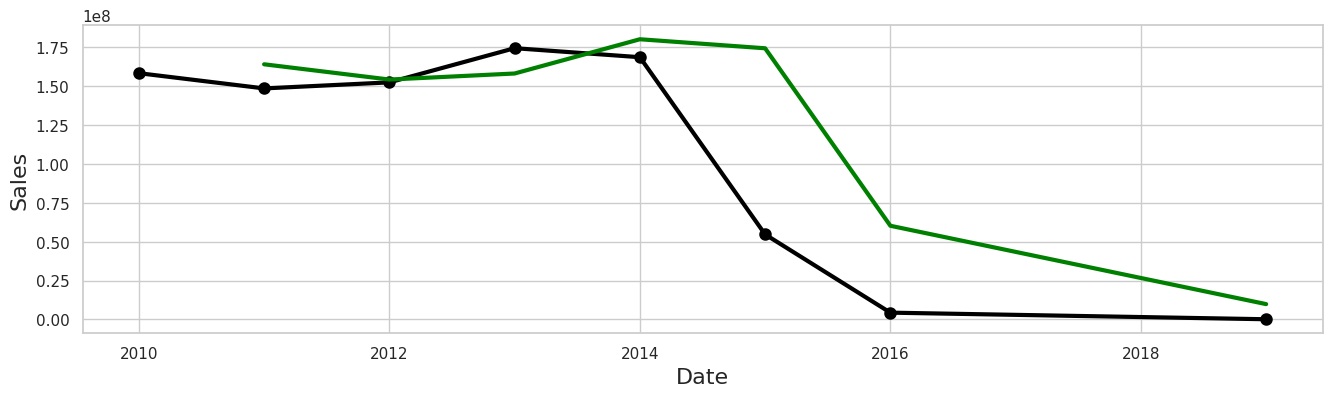

In [ ]:
y_pred = ar1.predict(time_test)
x_test = time_test['year'].to_numpy()
y_test = time_test['avg_gross'].to_numpy()
plot_last_fifty(x_test, y_test, green=y_pred)

In [ ]:
print('Auto-regressive Model OSR2:', round(OSR2(ar1, time_test, y_test, y), 5))

Auto-regressive Model OSR2: 0.59046


# Higher-order Auto-regressive Model

In [ ]:
time_train['AvgGrossLastTwoYear'] = time_train['avg_gross'].shift(2)
time_test['AvgGrossLastTwoYear'] = time_test['avg_gross'].shift(2)
ar2 = smf.ols(formula='avg_gross ~ AvgGrossLastYear + AvgGrossLastTwoYear', data=time_train).fit()
print(ar2.summary())

                            OLS Regression Results                            
Dep. Variable:              avg_gross   R-squared:                       0.891
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                     77.30
Date:                Sat, 09 Dec 2023   Prob (F-statistic):           7.46e-10
Time:                        04:48:42   Log-Likelihood:                -385.73
No. Observations:                  22   AIC:                             777.5
Df Residuals:                      19   BIC:                             780.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            4.733e+06   7

<ipython-input-32-fad2b9db3ef8>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-32-fad2b9db3ef8>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



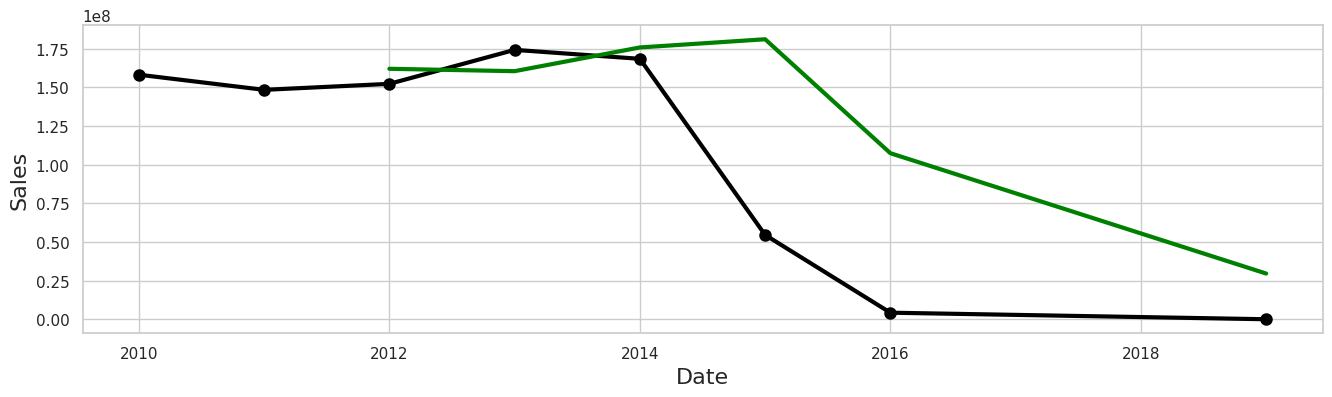

In [ ]:
y_pred = ar2.predict(time_test)
x_test = time_test['year'].to_numpy()
y_test = time_test['avg_gross'].to_numpy()
plot_last_fifty(x_test, y_test, green=y_pred)

In [ ]:
print('Higher-order Auto-regressive Model OSR2:', round(OSR2(ar2, time_test, y_test, y), 5))

Higher-order Auto-regressive Model OSR2: 0.37171


# Linear Regression

In [ ]:
from sklearn.model_selection import train_test_split
merged_df['gross_log'] = np.log(merged_df['gross'])
merged_df

# Split the data into training and testing sets
train, test = train_test_split(merged_df, test_size=0.3, random_state=42)

This is predicting gross revenue

In [ ]:
import statsmodels.formula.api as smf

# Should we use genre and/or rating... some of them were statistically sig, others were not.
model = smf.ols(formula='gross_log ~ rating + genre + score + votes + budget + runtime + CPI + year + month + day + dayofweek + star_studded + top_company + top_director + top_writer',
                data=train).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:              gross_log   R-squared:                       0.527
Model:                            OLS   Adj. R-squared:                  0.524
Method:                 Least Squares   F-statistic:                     205.5
Date:                Sat, 09 Dec 2023   Prob (F-statistic):               0.00
Time:                        04:48:42   Log-Likelihood:                -4012.3
No. Observations:                2413   AIC:                             8053.
Df Residuals:                    2399   BIC:                             8134.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      545.7508     75.197      7.258   

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1965: RuntimeWarning:

divide by zero encountered in double_scalars



In [ ]:

# Import the library that contains all the functions/modules related to the regression model
import statsmodels.api as sm

from statsmodels.stats.outliers_influence import variance_inflation_factor

def VIF(df, columns):
    values = sm.add_constant(df[columns]).values
    num_columns = len(columns)+1
    vif = [variance_inflation_factor(values, i) for i in range(num_columns)]
    return pd.Series(vif[1:], index=columns)


cols = ['rating','genre', 'score', 'votes', 'budget', 'runtime', 'CPI', 'year', 'month', 'day', 'dayofweek', 'star_studded', 'top_company', 'top_director','top_writer']
VIF(train, cols)

# when we ran VIF, a lot of the movies didn't have a budget included because of (blank) reasons. Our first thoughts were to do score, budget and CPI

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning:

invalid value encountered in double_scalars



rating            1.193000
genre             1.191261
score             1.571175
votes             1.692003
budget            1.902983
runtime           1.501563
CPI             141.160123
year            140.729163
month             1.062447
day               1.009763
dayofweek         1.050340
star_studded      1.166608
top_company       1.100834
top_director           NaN
top_writer             NaN
dtype: float64

NEW linear regression after removing some variables

In [ ]:
import statsmodels.formula.api as smf

# Should we use genre and/or rating... some of them were statistically sig, others were not.
model = smf.ols(formula='gross_log ~ rating + genre + score + votes + budget + month + dayofweek + star_studded + top_company',
                data=train).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              gross_log   R-squared:                       0.505
Model:                            OLS   Adj. R-squared:                  0.503
Method:                 Least Squares   F-statistic:                     272.3
Date:                Sat, 09 Dec 2023   Prob (F-statistic):               0.00
Time:                        04:48:42   Log-Likelihood:                -4067.0
No. Observations:                2413   AIC:                             8154.
Df Residuals:                    2403   BIC:                             8212.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       16.5316      0.244     67.844   

In [ ]:

# Import the library that contains all the functions/modules related to the regression model
import statsmodels.api as sm

from statsmodels.stats.outliers_influence import variance_inflation_factor

def VIF(df, columns):
    values = sm.add_constant(df[columns]).values
    num_columns = len(columns)+1
    vif = [variance_inflation_factor(values, i) for i in range(num_columns)]
    return pd.Series(vif[1:], index=columns)


cols = ['rating','genre', 'score', 'votes', 'budget', 'month', 'dayofweek', 'star_studded', 'top_company']
VIF(train, cols)


rating          1.104862
genre           1.177802
score           1.408501
votes           1.659788
budget          1.601325
month           1.038204
dayofweek       1.041065
star_studded    1.134619
top_company     1.084622
dtype: float64

## Baseline Model for Logistic Regression

In [ ]:
# How many movies have are a success in the training set?

success_false = np.sum(train['success'] == 0)
success_true = np.sum(train['success'] == 1)

print(pd.Series({'0': success_false, '1': success_true}))

0    1258
1    1155
dtype: int64


## Accuracy of Baseline Model on Test data

In [ ]:
# Accuracy of baseline model based on training data:
ACC = success_false/(success_false + success_true)
ACC

0.5213427268959802

## Logistic Regression




In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd


# Copy the dataframe
merged_copydf = merged_df.copy()

# Extract features (X) and target variable (y)
X = merged_copydf[['rating', 'genre', 'score', 'votes', 'CPI', 'budget', 'runtime', 'year', 'month', 'day', 'dayofweek', 'star_studded', 'top_company', 'top_director', 'top_writer']]
y = merged_copydf['success']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features (optional but can be beneficial for logistic regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create a logistic regression model
logistic_model = LogisticRegression(random_state=42)

# Train the model on the training set
logistic_model.fit(X_train_scaled, y_train)

# Make predictions on the testing set
y_pred = logistic_model.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(classification_rep)

Accuracy: 0.7580

Confusion Matrix:
[[329  42]
 [125 194]]

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.89      0.80       371
           1       0.82      0.61      0.70       319

    accuracy                           0.76       690
   macro avg       0.77      0.75      0.75       690
weighted avg       0.77      0.76      0.75       690



##Feature Importance for Logistic Regression
Here, the variable coefficients will contain the coefficients of the logistic regression model, and we can examine their values to understand the importance of each feature. Positive coefficients indicate a positive impact on the log-odds of the target, while negative coefficients indicate a negative impact.


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Assuming X and y are your features and target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features (optional but can be beneficial for logistic regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create a logistic regression model
logistic_model = LogisticRegression(random_state=42)

# Train the model on the training set
logistic_model.fit(X_train_scaled, y_train)

# Access the coefficients
coefficients = logistic_model.coef_[0]

# Map coefficients to corresponding feature names
feature_names = X.columns

# Create a DataFrame to display the coefficients
coefficients_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Display the coefficients
print(coefficients_df)

#genre, score, votes, CPI, day, dayofweek, star_studded, top_company, top_director, top_writer



         Feature  Coefficient
0         rating    -0.283072
1          genre     0.202014
2          score     0.008656
3          votes     2.541849
4            CPI     1.194334
5         budget    -0.522364
6        runtime    -0.209936
7           year    -1.097465
8          month    -0.096681
9            day     0.005936
10     dayofweek     0.036779
11  star_studded     0.058413
12   top_company     0.144757
13  top_director     0.000000
14    top_writer     0.000000


## Making logreg with just highest coefficients to maximize accuracy

In [ ]:
X = merged_copydf[['rating', 'genre', 'votes', 'CPI', 'budget', 'runtime', 'year', 'month', 'day', 'top_company']]
y = merged_copydf['success']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features (optional but can be beneficial for logistic regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create a logistic regression model
logistic_model = LogisticRegression(random_state=42)

# Train the model on the training set
logistic_model.fit(X_train_scaled, y_train)

# Make predictions on the testing set
y_pred = logistic_model.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(classification_rep)

Accuracy: 0.7623

Confusion Matrix:
[[329  42]
 [122 197]]

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.89      0.80       371
           1       0.82      0.62      0.71       319

    accuracy                           0.76       690
   macro avg       0.78      0.75      0.75       690
weighted avg       0.77      0.76      0.76       690



## Visualizing LogReg Coefficients

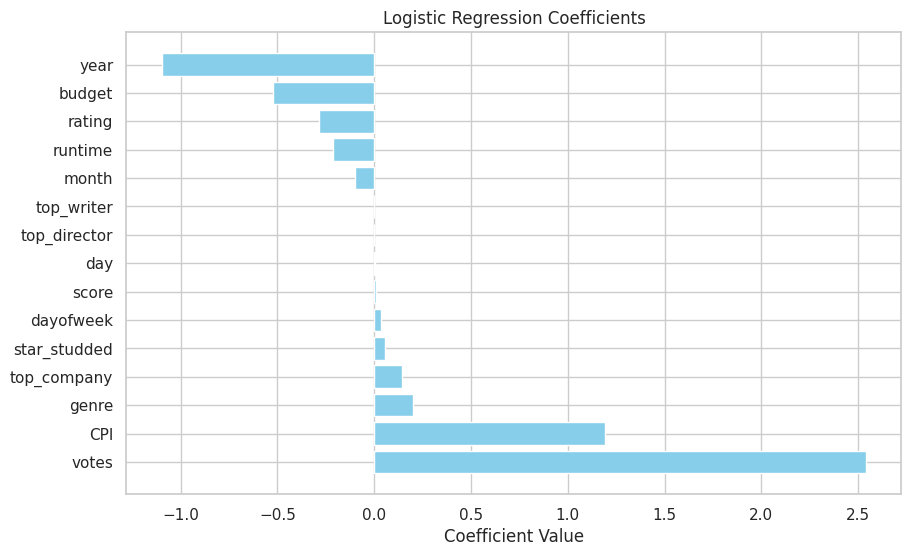

In [ ]:
import matplotlib.pyplot as plt

coefficients_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Sort the coefficients for better visualization
coefficients_df = coefficients_df.sort_values(by='Coefficient', ascending=False)

# Plot the coefficients
plt.figure(figsize=(10, 6))
plt.barh(coefficients_df['Feature'], coefficients_df['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Value')
plt.title('Logistic Regression Coefficients')
plt.show()

# Baseline Model

## Random Forest Regressor Predicting Gross_Log

In [ ]:
from sklearn.ensemble import RandomForestRegressor

regressor_df = merged_df.copy()
# Regressor because y is gross log and is continuous, need to use regressor

X = regressor_df[['rating', 'genre', 'score', 'votes', 'budget', 'runtime', 'CPI', 'year', 'month', 'day', 'dayofweek', 'star_studded', 'top_company', 'top_director', 'top_writer']]
y = regressor_df['gross_log']
X_train_gross, X_test_gross, y_train_gross, y_test_gross = train_test_split(X, y, test_size=0.2, random_state=42)
rf_regressor = RandomForestRegressor(n_estimators = 100, random_state = 42)
rf_regressor.fit(X_train_gross, y_train_gross)
regressor_predictions = rf_regressor.predict(X_test_gross)
regressor_predictions[:10]

array([17.76695396, 15.96509895, 14.78580832, 19.58786994, 17.38618006,
       17.5161877 , 17.25458305, 19.21338936, 19.39546015, 16.34983504])

In [ ]:
y_train_gross

59      14.081801
2328    15.426527
4116    20.822255
3065    18.148641
3801    18.988870
          ...    
1592    15.570095
1641    16.331545
1850    18.667841
1284    15.633469
3910    18.601102
Name: gross_log, Length: 2758, dtype: float64

In [ ]:
rating_counts = merged_df['rating'].value_counts().sort_index()
print(rating_counts)

0      73
1       4
2       6
3     531
4    1203
5    1620
6      11
Name: rating, dtype: int64


In [ ]:
genre_counts = merged_df['genre'].value_counts().sort_index()
print(genre_counts)

0      886
1      185
2      164
3      147
4     1091
5      271
6      507
7        2
8       27
9      146
10      13
11       2
12       3
13       4
Name: genre, dtype: int64


In [ ]:
votes_counts = merged_df['votes'].value_counts().sort_index()
votes_counts.head(30)

390.0     1
525.0     1
694.0     1
716.0     1
759.0     1
822.0     1
834.0     1
872.0     1
905.0     1
906.0     1
943.0     1
949.0     1
994.0     1
1000.0    2
1100.0    4
1200.0    5
1300.0    1
1400.0    3
1500.0    5
1600.0    5
1700.0    4
1800.0    5
1900.0    6
2000.0    2
2100.0    6
2200.0    5
2300.0    3
2400.0    1
2500.0    5
2600.0    8
Name: votes, dtype: int64

In [ ]:
maxruntime = merged_df['runtime'].max()
maxruntime

271.0

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

mae = mean_absolute_error(y_test_gross, regressor_predictions)
mse = mean_squared_error(y_test_gross, regressor_predictions)
rmse = mean_squared_error(y_test_gross, regressor_predictions, squared=False)
r_squared = r2_score(y_test_gross, regressor_predictions)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R-squared: {r_squared}")

Mean Absolute Error: 0.7143657210666777
Mean Squared Error: 1.0711844393827565
Root Mean Squared Error: 1.0349804053134322
R-squared: 0.6894174448297832


In [ ]:
feature_importance = rf_regressor.feature_importances_
feature_importance_with_columns = list(zip(X.columns, rf_regressor.feature_importances_))

sorted_feature_importance = sorted(feature_importance_with_columns, key=lambda x: x[1], reverse=True)

for feature, importance in sorted_feature_importance:
    print(f"Feature: {feature}, Importance: {importance}")

Feature: votes, Importance: 0.5146731966557205
Feature: budget, Importance: 0.24016869133857735
Feature: score, Importance: 0.03919955854890713
Feature: year, Importance: 0.03007376443719557
Feature: runtime, Importance: 0.02978549600821744
Feature: day, Importance: 0.029733905391934035
Feature: month, Importance: 0.023363942249271758
Feature: dayofweek, Importance: 0.02250037163567404
Feature: CPI, Importance: 0.020803736812999952
Feature: genre, Importance: 0.02011198019915201
Feature: rating, Importance: 0.018433638365393537
Feature: top_company, Importance: 0.007813242298905593
Feature: star_studded, Importance: 0.0033384760580511797
Feature: top_director, Importance: 0.0
Feature: top_writer, Importance: 0.0


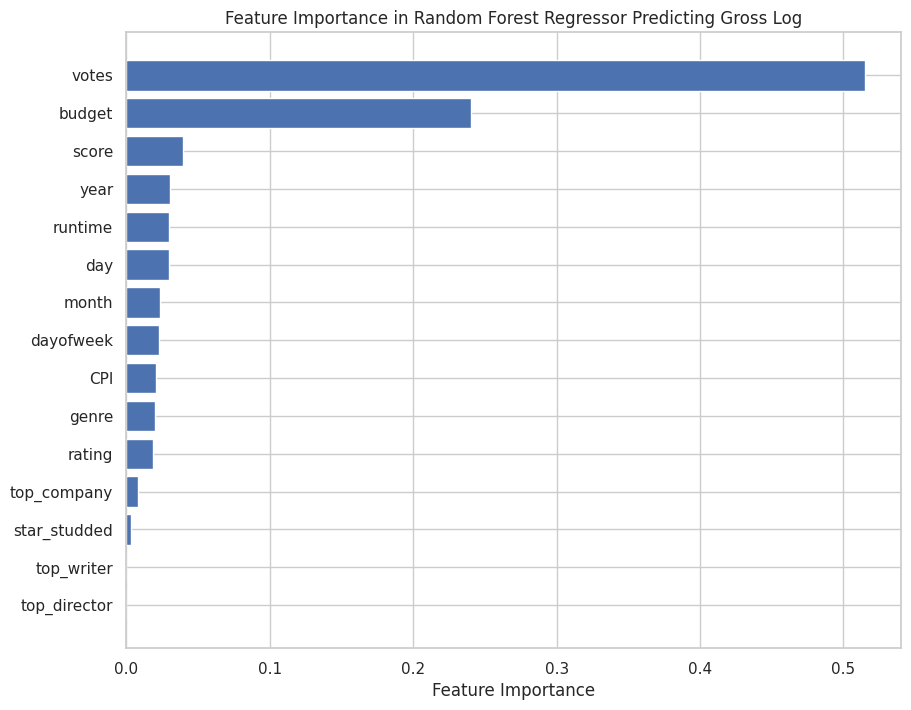

In [ ]:
feature_importance = rf_regressor.feature_importances_
sorted_idx = feature_importance.argsort()
features = ['rating', 'genre', 'score', 'votes', 'budget', 'runtime', 'CPI', 'year', 'month', 'day', 'dayofweek', 'star_studded', 'top_company', 'top_director', 'top_writer']
plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [features[i] for i in sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Feature Importance in Random Forest Regressor Predicting Gross Log')
plt.show()

# Random Forest Regressor Predicting Gross Log with Grid Search CV

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [50, 100, 150],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [1, 5, 10]
}

random_search = RandomizedSearchCV(estimator=rf_regressor, param_distributions=param_grid,
                                   scoring='r2', cv=5, n_jobs=-1, n_iter=20)

random_search.fit(X_train_gross, y_train_gross)
best_params = random_search.best_params_
best_score = random_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"R Sqaured Value: {best_score}")

Best Parameters: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_depth': 100}
R Sqaured Value: 0.7173648296922218


In [ ]:
# Using RF Regressor with the Best Parameters found from Grid Search
rf_best_regressor = RandomForestRegressor(n_estimators=100, min_samples_split=5, min_samples_leaf=5, max_depth=50)

# rf_best_regressor = RandomForestRegressor(n_estimators=150, min_samples_split=10, min_samples_leaf=5, max_depth=150) # got it using different random forest regressor for grid cv

rf_best_regressor.fit(X_train_gross, y_train_gross)

reg_grid_predictions = rf_best_regressor.predict(X_test_gross)

mae = mean_absolute_error(y_test_gross, reg_grid_predictions)
mse = mean_squared_error(y_test_gross, reg_grid_predictions)
rmse = mean_squared_error(y_test_gross, reg_grid_predictions, squared=False)
r_squared = r2_score(y_test_gross, reg_grid_predictions)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R-squared: {r_squared}")

Mean Absolute Error: 0.7065755033622995
Mean Squared Error: 1.0583852256481894
Root Mean Squared Error: 1.0287785114630794
R-squared: 0.6931284887543404


In [ ]:
feature_importance = rf_best_regressor.feature_importances_
feature_importance_with_columns = list(zip(X.columns, rf_best_regressor.feature_importances_))

sorted_feature_importance = sorted(feature_importance_with_columns, key=lambda x: x[1], reverse=True)

for feature, importance in sorted_feature_importance:
    print(f"Feature: {feature}, Importance: {importance}")

Feature: votes, Importance: 0.5618668180350643
Feature: budget, Importance: 0.2650529081943921
Feature: score, Importance: 0.026864600860934167
Feature: day, Importance: 0.01985260978534669
Feature: year, Importance: 0.019544890552249134
Feature: dayofweek, Importance: 0.019504635989403694
Feature: runtime, Importance: 0.01881625427454522
Feature: rating, Importance: 0.015597824752798497
Feature: month, Importance: 0.015502850688256044
Feature: CPI, Importance: 0.015119513693916967
Feature: genre, Importance: 0.012133427828112381
Feature: top_company, Importance: 0.008761270503350255
Feature: star_studded, Importance: 0.0013823948416303573
Feature: top_director, Importance: 0.0
Feature: top_writer, Importance: 0.0


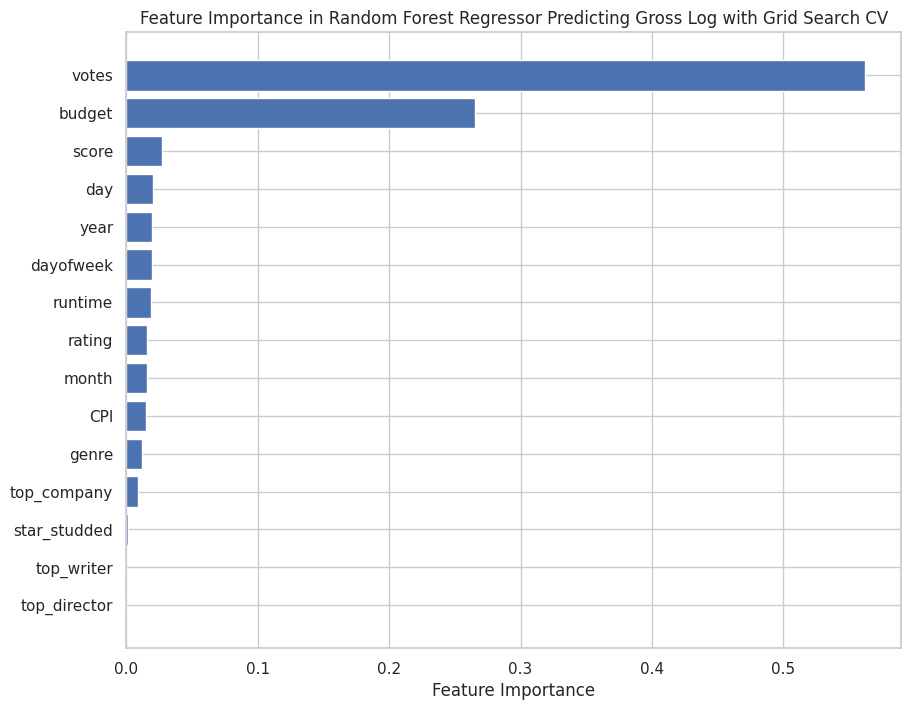

In [ ]:
feature_importance = rf_best_regressor.feature_importances_
sorted_idx = feature_importance.argsort()
features = ['rating', 'genre', 'score', 'votes', 'budget', 'runtime', 'CPI', 'year', 'month', 'day', 'dayofweek', 'star_studded', 'top_company', 'top_director', 'top_writer']
plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [features[i] for i in sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Feature Importance in Random Forest Regressor Predicting Gross Log with Grid Search CV')
plt.show()

## Random Forest Classifier Predicting Success

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

merged_copy = merged_df.copy()
# because y is now binary, use classifier
# X = merged_copy[['rating', 'genre', 'score', 'votes', 'budget', 'company', 'runtime','CPI', 'month', 'dayofweek', 'top_company', 'star_studded']]
X = merged_copy[['rating', 'genre', 'score', 'votes', 'CPI', 'budget', 'runtime', 'year', 'month', 'day', 'dayofweek', 'star_studded', 'top_company', 'top_director', 'top_writer']]
y = merged_copy['success']
X_train_success, X_test_success, y_train_success, y_test_success = train_test_split(X, y, test_size=0.2, random_state=42)
rf_classifier = RandomForestClassifier(n_estimators = 100, random_state = 42)
rf_classifier.fit(X_train_success, y_train_success)
predictions_classifier = rf_classifier.predict(X_test_success)
predictions_classifier[:10]

array([0, 0, 0, 1, 1, 0, 0, 1, 1, 1])

In [ ]:
success_accuracy = accuracy_score(y_test_success, predictions_classifier)
print("Accuracy: ", success_accuracy)

Accuracy:  0.7695652173913043


In [ ]:
feature_importance = rf_classifier.feature_importances_
feature_importance_with_columns = list(zip(X.columns, rf_classifier.feature_importances_))

sorted_feature_importance = sorted(feature_importance_with_columns, key=lambda x: x[1], reverse=True)

for feature, importance in sorted_feature_importance:
    print(f"Feature: {feature}, Importance: {importance}")

Feature: votes, Importance: 0.2765193403036301
Feature: budget, Importance: 0.11761335763690922
Feature: score, Importance: 0.10197413849282104
Feature: runtime, Importance: 0.08695770301678268
Feature: day, Importance: 0.07664650637293534
Feature: CPI, Importance: 0.07400374826890492
Feature: year, Importance: 0.07251088168553847
Feature: month, Importance: 0.06266338487032035
Feature: genre, Importance: 0.05035786026022307
Feature: rating, Importance: 0.033031409518777
Feature: top_company, Importance: 0.01701545331562326
Feature: dayofweek, Importance: 0.01583368664999923
Feature: star_studded, Importance: 0.014872529607535354
Feature: top_director, Importance: 0.0
Feature: top_writer, Importance: 0.0


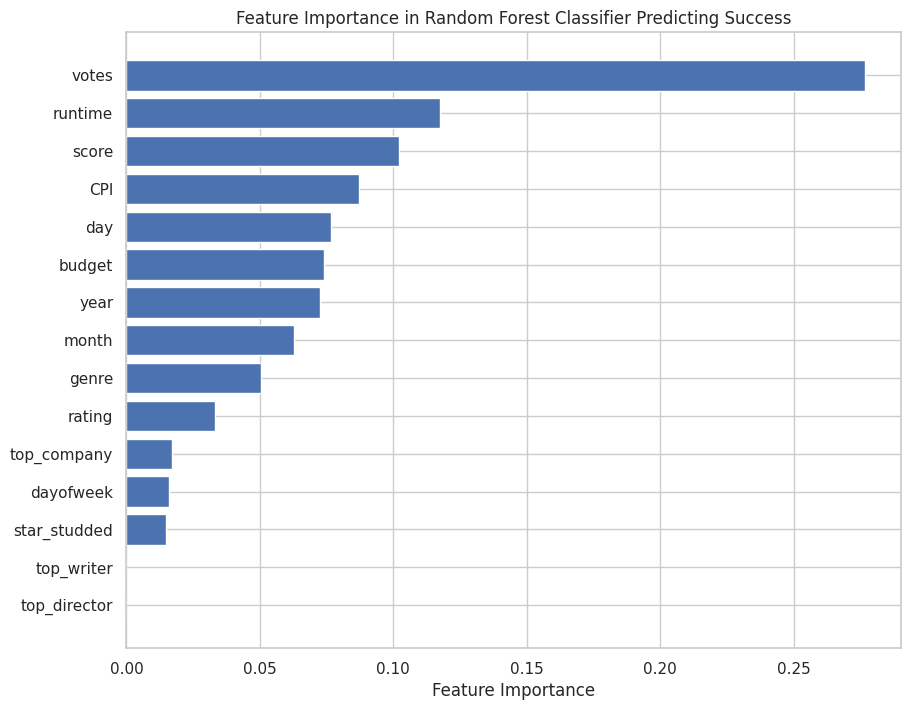

In [ ]:
feature_importance = rf_classifier.feature_importances_
sorted_idx = feature_importance.argsort()
features = ['rating', 'genre', 'score', 'votes', 'budget', 'runtime', 'CPI', 'year', 'month', 'day', 'dayofweek', 'star_studded', 'top_company', 'top_director', 'top_writer']
plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [features[i] for i in sorted_idx])

plt.xlabel('Feature Importance')
plt.title('Feature Importance in Random Forest Classifier Predicting Success')
plt.show()


## Random Forest Classifier Predicting Success Using Grid Search CV

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [50, 100, 150],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [1, 5, 10]
}

random_search = RandomizedSearchCV(estimator=rf_classifier, param_distributions=param_grid,
                                   scoring='accuracy', cv=5, n_jobs=-1, n_iter=20)

random_search.fit(X_train_success, y_train_success)
best_params = random_search.best_params_
best_score = random_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Accuracy: {best_score}")

Best Parameters: {'n_estimators': 100, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_depth': 100}
Accuracy: 0.7541669954496435


In [ ]:
rf_best_classifier = RandomForestClassifier(n_estimators=100, min_samples_split=10, min_samples_leaf=1, max_depth=50)
rf_best_classifier.fit(X_train_success, y_train_success)
pred_class = rf_classifier.predict(X_test_success)
best_accuracy_classifier = accuracy_score(y_test_success, pred_class)
print("Accuracy: ", best_accuracy_classifier)

Accuracy:  0.7695652173913043


In [ ]:
feature_importance = rf_best_classifier.feature_importances_
feature_importance_with_columns = list(zip(X.columns, rf_best_classifier.feature_importances_))
sorted_feature_importance = sorted(feature_importance_with_columns, key=lambda x: x[1], reverse=True)

for feature, importance in sorted_feature_importance:
    print(f"Feature: {feature}, Importance: {importance}")

Feature: votes, Importance: 0.3297855167341814
Feature: budget, Importance: 0.11383262077839132
Feature: score, Importance: 0.10337423117951898
Feature: runtime, Importance: 0.08140915279877567
Feature: year, Importance: 0.07173649460931092
Feature: CPI, Importance: 0.06801102251827038
Feature: day, Importance: 0.06311021101098596
Feature: month, Importance: 0.04925959132657388
Feature: genre, Importance: 0.046489764468977346
Feature: rating, Importance: 0.03018407247609439
Feature: dayofweek, Importance: 0.015358760225303664
Feature: top_company, Importance: 0.014516355647435173
Feature: star_studded, Importance: 0.012932206226181063
Feature: top_director, Importance: 0.0
Feature: top_writer, Importance: 0.0


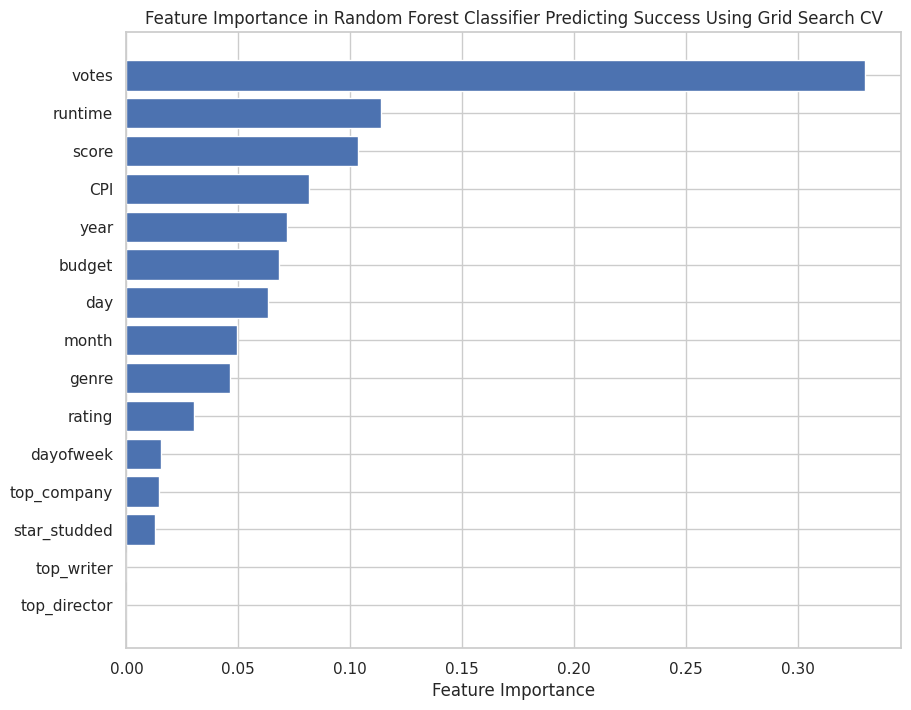

In [ ]:
feature_importance = rf_best_classifier.feature_importances_
sorted_idx = feature_importance.argsort()
features = ['rating', 'genre', 'score', 'votes', 'budget', 'runtime', 'CPI', 'year', 'month', 'day', 'dayofweek', 'star_studded', 'top_company', 'top_director', 'top_writer']
plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [features[i] for i in sorted_idx])

plt.xlabel('Feature Importance')
plt.title('Feature Importance in Random Forest Classifier Predicting Success Using Grid Search CV')
plt.show()

# Gradient Boosting for Regressor Predicting Gross Log

In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


xgb_reg = XGBRegressor(n_estimators=100, random_state=42)
xgb_reg.fit(X_train_gross, y_train_gross)
xgb_pred = xgb_reg.predict(X_test_gross)

mae_xgb = mean_absolute_error(y_test_gross, xgb_pred)
mse_xgb = mean_squared_error(y_test_gross, xgb_pred)
rmse_xgb = mean_squared_error(y_test_gross, xgb_pred, squared=False)
r2_xgb = r2_score(y_test_gross, xgb_pred)

print(f"Mean Absolute Error:, {mae_xgb}")
print(f"Mean Squared Error:, {mse_xgb}")
print(f"Root Mean Squared Error:, {rmse_xgb}")
print(f"R-squared:, {r2_xgb}")

Mean Absolute Error:, 0.7229699302767546
Mean Squared Error:, 1.1045339190066026
Root Mean Squared Error:, 1.0509680865785613
R-squared:, 0.6797479927593819


In [ ]:
feature_importance = xgb_reg.feature_importances_
feature_importance_with_columns = list(zip(X.columns, xgb_reg.feature_importances_))

sorted_feature_importance = sorted(feature_importance_with_columns, key=lambda x: x[1], reverse=True)

for feature, importance in sorted_feature_importance:
    print(f"Feature: {feature}, Importance: {importance}")

Feature: votes, Importance: 0.3352856934070587
Feature: CPI, Importance: 0.2074228823184967
Feature: dayofweek, Importance: 0.1138455793261528
Feature: top_company, Importance: 0.08118757605552673
Feature: year, Importance: 0.05282525718212128
Feature: rating, Importance: 0.037791941314935684
Feature: runtime, Importance: 0.03321843966841698
Feature: month, Importance: 0.027221733704209328
Feature: score, Importance: 0.026812521740794182
Feature: budget, Importance: 0.0248651672154665
Feature: day, Importance: 0.020781777799129486
Feature: genre, Importance: 0.0202829260379076
Feature: star_studded, Importance: 0.018458448350429535
Feature: top_director, Importance: 0.0
Feature: top_writer, Importance: 0.0


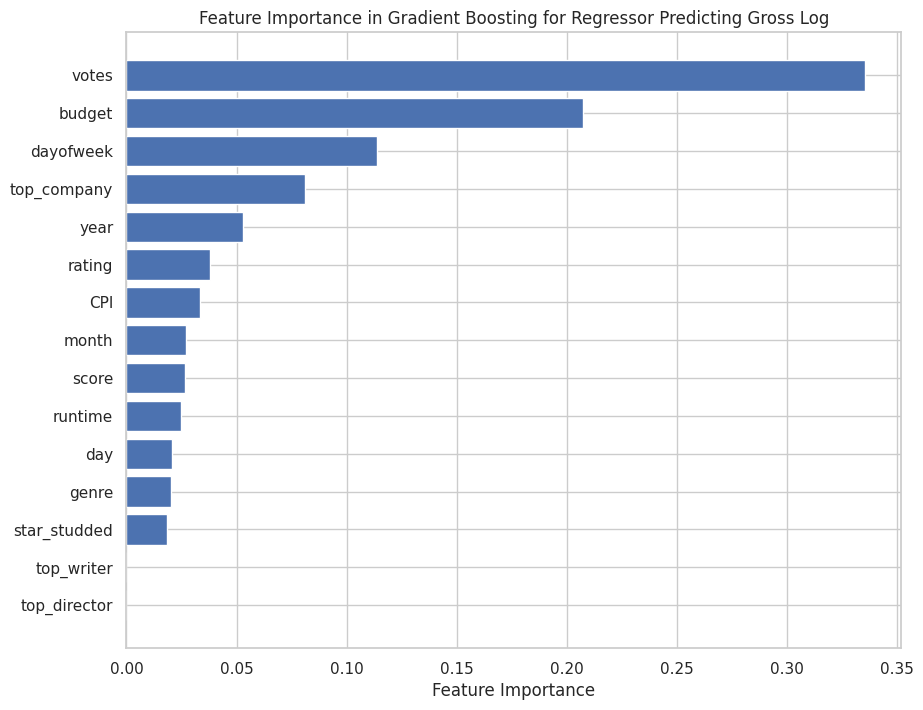

In [ ]:
feature_importance = xgb_reg.feature_importances_
sorted_idx = feature_importance.argsort()
features = ['rating', 'genre', 'score', 'votes', 'budget', 'runtime', 'CPI', 'year', 'month', 'day', 'dayofweek', 'star_studded', 'top_company', 'top_director', 'top_writer']
plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [features[i] for i in sorted_idx])

plt.xlabel('Feature Importance')
plt.title('Feature Importance in Gradient Boosting for Regressor Predicting Gross Log')
plt.show()

# Gradient Boosting for Classifier Predicting Success

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

xgb_cls = XGBClassifier(n_estimators=100, random_state=42)
xgb_cls.fit(X_train_success, y_train_success)
xgb_pred_class = xgb_cls.predict(X_test_success)

accuracy = accuracy_score(y_test_success, xgb_pred_class)
precision = precision_score(y_test_success, xgb_pred_class)
recall = recall_score(y_test_success, xgb_pred_class)
f1 = f1_score(y_test_success, xgb_pred_class)
conf_matrix = confusion_matrix(y_test_success, xgb_pred_class)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion Matrix:\n{conf_matrix}")

Accuracy: 0.7869565217391304
Precision: 0.7670807453416149
Recall: 0.774294670846395
F1 Score: 0.7706708268330734
Confusion Matrix:
[[296  75]
 [ 72 247]]


In [ ]:
feature_importance = xgb_cls.feature_importances_
feature_importance_with_columns = list(zip(X.columns, xgb_cls.feature_importances_))

sorted_feature_importance = sorted(feature_importance_with_columns, key=lambda x: x[1], reverse=True)

for feature, importance in sorted_feature_importance:
    print(f"Feature: {feature}, Importance: {importance}")

Feature: votes, Importance: 0.18234607577323914
Feature: budget, Importance: 0.10010498762130737
Feature: rating, Importance: 0.08933472633361816
Feature: dayofweek, Importance: 0.08091221749782562
Feature: top_company, Importance: 0.07753637433052063
Feature: score, Importance: 0.06885712593793869
Feature: CPI, Importance: 0.06724940985441208
Feature: genre, Importance: 0.06197649985551834
Feature: year, Importance: 0.061929017305374146
Feature: month, Importance: 0.05839427560567856
Feature: runtime, Importance: 0.05737367644906044
Feature: day, Importance: 0.05204277113080025
Feature: star_studded, Importance: 0.04194279760122299
Feature: top_director, Importance: 0.0
Feature: top_writer, Importance: 0.0


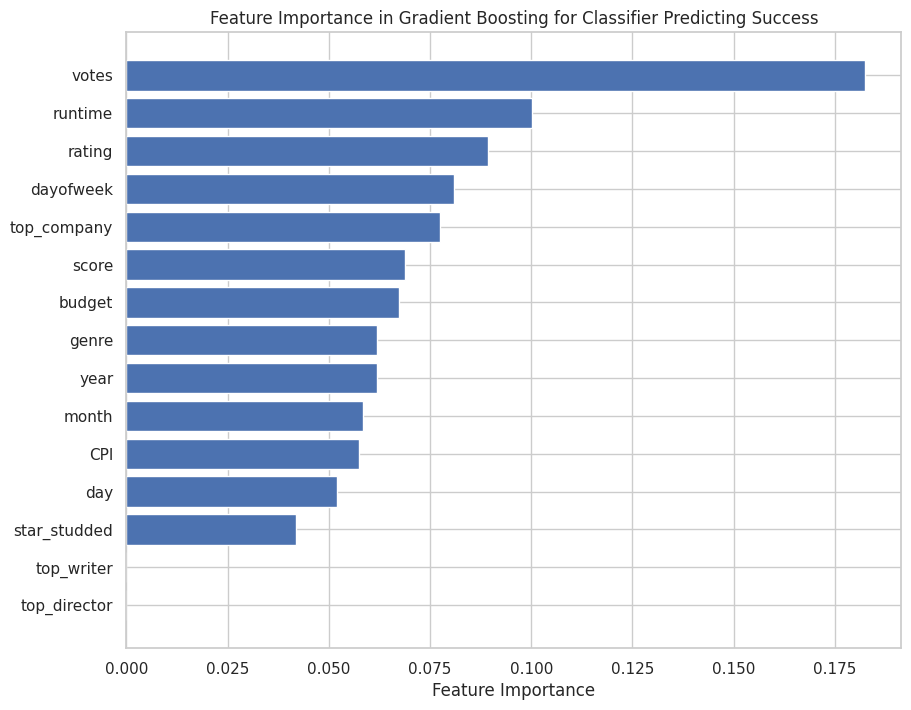

In [ ]:
feature_importance = xgb_cls.feature_importances_
sorted_idx = feature_importance.argsort()
features = ['rating', 'genre', 'score', 'votes', 'budget', 'runtime', 'CPI', 'year', 'month', 'day', 'dayofweek', 'star_studded', 'top_company', 'top_director', 'top_writer']
plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [features[i] for i in sorted_idx])

plt.xlabel('Feature Importance')
plt.title('Feature Importance in Gradient Boosting for Classifier Predicting Success')
plt.show()

In [ ]:
# Importance values for each feature across different categories
votes = [0.5149157348655525, 0.5700307879381045, 0.2754866760084887, 0.33768728361309786, 0.3186371922492981, 0.19338540732860565, 0.3547568763955934]
budget = [0.23996041400683363, 0.2605729570318566, 0.11698957030326226, 0.1159601906438301, 0.1159601906438301, 0.10160606354475021, 0.13785617464629896]
score = [0.03938769786621848, 0.026414445439291313, 0.10244215228374642, 0.10405206496344299, 0.10405206496344299, 0.07615770399570465, 0.08882447721255791]
day = [0.030056812163374316, 0.01934230749328846, 0.07718101190014205, 0.061042470677589146, 0.06365488058361506, 0.09229359785986137, 0.0]
runtime = [0.029872492419931524, 0.01798541163464375, 0.08811955861165793, 0.07873920056017943, 0.07873920056017943, 0.058316051959991455, 0.0]
year = [0.028922446530147278, 0.02045232206001599, 0.07262319401475943, 0.06702216286450541, 0.06702216286450541, 0.04333887617892185, 0.0]
month = [0.022990192751109948, 0.013978144397990545, 0.061575059651300876, 0.04892347480597939, 0.04892347480597939, 0.056169286370277405, 0.0]
dayofweek = [0.02192495211056887, 0.019512101658096685, 0.015974232189264213, 0.015284921589842081, 0.015284921589842081, 0.0070314587943782715, 0.0]
CPI = [0.021810973701890366, 0.014232017008596139, 0.0735355966238887, 0.06502808517545698, 0.06502808517545698, 0.07056299597024918, 0.0]
genre = [0.02069049739528874, 0.013085208724765391, 0.05102434878833597, 0.046752856714887846, 0.046752856714887846, 0.07181774824857712, 0.0]
rating = [0.018379072595571627, 0.015226260588228256, 0.032735622019295314, 0.030824282141255526, 0.030824282141255526, 0.09250235557556152, 0.0]
star_studded = [0.0033648335398659456, 0.0016030805091884332, 0.014947493682913022, 0.013195264871152947, 0.013195264871152947, 0.04713525250554085, 0.0]
top_company = [0.007723880053646835, 0.007564955515934008, 0.017365483922945263, 0.015487741378780364, 0.015487741378780364, 0.01924954331619059, 0.0]
top_director = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
top_writer = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

# Summing the importance values for each feature
total_votes = sum(votes)
total_budget = sum(budget)
total_score = sum(score)
total_day = sum(day)
total_runtime = sum(runtime)
total_year = sum(year)
total_month = sum(month)
total_dayofweek = sum(dayofweek)
total_CPI = sum(CPI)
total_genre = sum(genre)
total_rating = sum(rating)
total_star_studded = sum(star_studded)
total_top_company = sum(top_company)
total_top_director = sum(top_director)
total_top_writer = sum(top_writer)

# Displaying the summed importance values for each feature
print(f"votes = {total_votes}")
print(f"budget = {total_budget}")
print(f"score = {total_score}")
print(f"day = {total_day}")
print(f"runtime = {total_runtime}")
print(f"year = {total_year}")
print(f"month = {total_month}")
print(f"dayofweek = {total_dayofweek}")
print(f"CPI = {total_CPI}")
print(f"genre = {total_genre}")
print(f"rating = {total_rating}")
print(f"star_studded = {total_star_studded}")
print(f"top_company = {total_top_company}")
print(f"top_director = {total_top_director}")
print(f"top_writer = {total_top_writer}")


votes = 2.564899958398741
budget = 1.088905560820662
score = 0.5413306067244048
day = 0.3435710806778704
runtime = 0.3517719157465835
year = 0.29938116451285535
month = 0.25255963278263754
dayofweek = 0.09501258793199222
CPI = 0.31019775365553837
genre = 0.2501235165867429
rating = 0.22049187506116777
star_studded = 0.09344118997981414
top_company = 0.08287934556627743
top_director = 0.0
top_writer = 0.0


# CART

In [ ]:
from sklearn.model_selection import train_test_split
X = merged_df[['rating', 'genre', 'score', 'votes', 'budget', 'runtime', 'CPI', 'year', 'month', 'day', 'dayofweek', 'star_studded', 'top_company', 'top_director', 'top_writer']]
y = merged_df['success']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X

,rating,genre,score,votes,budget,runtime,CPI,year,month,day,dayofweek,star_studded,top_company,top_director,top_writer
0,3,0,6.9,306000.0,15000000.0,110.0,50.262433,1986,5,16,0,1,1,0,0
1,5,1,8.1,374000.0,8000000.0,89.0,50.262433,1986,8,22,0,0,1,0,0
2,4,4,7.8,330000.0,6000000.0,103.0,50.262433,1986,6,11,6,1,1,0,0
3,4,0,7.3,128000.0,25000000.0,99.0,50.262433,1986,7,2,6,1,1,0,0
4,4,4,6.8,76000.0,9000000.0,97.0,50.262433,1986,2,28,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4212,3,2,6.0,17000.0,50000000.0,83.0,108.566932,2014,7,18,0,0,0,0,0
4213,5,4,6.4,26000.0,12000000.0,102.0,108.566932,2014,12,12,0,0,0,0,0
4214,5,6,7.1,32000.0,8000000.0,112.0,108.566932,2015,10,9,0,0,0,0,0
4215,4,6,6.6,12000.0,9000000.0,121.0,108.566932,2015,1,30,0,1,0,0,0


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of CART model: {accuracy:.2f}")

# Calculate other evaluation metrics
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{conf_matrix}")

# Classification Report
class_report = classification_report(y_test, y_pred)
print(f"Classification Report:\n{class_report}")

Accuracy of CART model: 0.72
Confusion Matrix:
[[277  94]
 [100 219]]
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.75      0.74       371
           1       0.70      0.69      0.69       319

    accuracy                           0.72       690
   macro avg       0.72      0.72      0.72       690
weighted avg       0.72      0.72      0.72       690



In [ ]:
feature_importance = clf.feature_importances_
feature_importance_with_columns = list(zip(X.columns, clf.feature_importances_))

sorted_feature_importance = sorted(feature_importance_with_columns, key=lambda x: x[1], reverse=True)

for feature, importance in sorted_feature_importance:
    print(f"Feature: {feature}, Importance: {importance}")

Feature: votes, Importance: 0.35254048851306496
Feature: budget, Importance: 0.1422368947912367
Feature: score, Importance: 0.09125675654562723
Feature: runtime, Importance: 0.08929444057114097
Feature: CPI, Importance: 0.061729306608173586
Feature: day, Importance: 0.06160771230614788
Feature: month, Importance: 0.05897717209634031
Feature: year, Importance: 0.03777420087029169
Feature: genre, Importance: 0.036455969014921714
Feature: rating, Importance: 0.026614131336187567
Feature: top_company, Importance: 0.01876474264344616
Feature: dayofweek, Importance: 0.015538506127321897
Feature: star_studded, Importance: 0.007209678576099294
Feature: top_director, Importance: 0.0
Feature: top_writer, Importance: 0.0


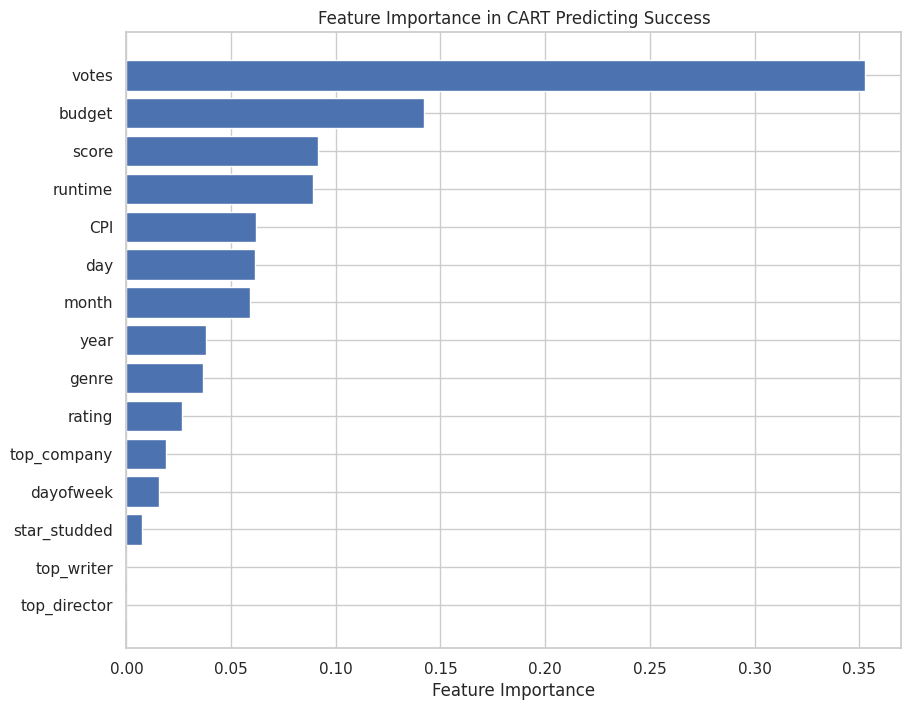

In [ ]:
feature_importance = clf.feature_importances_
sorted_idx = feature_importance.argsort()
features = ['rating', 'genre', 'score', 'votes', 'budget', 'runtime', 'CPI', 'year', 'month', 'day', 'dayofweek', 'star_studded', 'top_company', 'top_director', 'top_writer']
plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [features[i] for i in sorted_idx])

plt.xlabel('Feature Importance')
plt.title('Feature Importance in CART Predicting Success')
plt.show()

Imputing Null Budgets

In [ ]:
median_budget_by_genre = merged_df_copy.groupby('genre')['budget'].median()

genre_median_budget_dict = median_budget_by_genre.to_dict()

def impute_budget(row):
    if pd.isnull(row['budget']):
        return genre_median_budget_dict.get(row['genre'])
    else:
        return row['budget']

merged_df_copy['budget'] = merged_df_copy.apply(impute_budget, axis=1)
merged_df_copy

,name,rating,genre,Year,released,score,votes,director,writer,star,country,budget,gross,company,runtime,CPI,success
0,Top Gun,PG,Action,1986,"May 16, 1986 (United States)",6.9,306000.0,Tony Scott,Jim Cash,Tom Cruise,United States,15000000.0,357288178.0,Paramount Pictures,110.0,50.262433,1
1,Stand by Me,R,Adventure,1986,"August 22, 1986 (United States)",8.1,374000.0,Rob Reiner,Stephen King,Wil Wheaton,United States,8000000.0,52287414.0,Columbia Pictures,89.0,50.262433,1
2,Ferris Bueller's Day Off,PG-13,Comedy,1986,"June 11, 1986 (United States)",7.8,330000.0,John Hughes,John Hughes,Matthew Broderick,United States,6000000.0,70720215.0,Paramount Pictures,103.0,50.262433,1
3,Big Trouble in Little China,PG-13,Action,1986,"July 2, 1986 (United States)",7.3,128000.0,John Carpenter,Gary Goldman,Kurt Russell,United States,25000000.0,11100577.0,Twentieth Century Fox,99.0,50.262433,0
4,Pretty in Pink,PG-13,Comedy,1986,"February 28, 1986 (United States)",6.8,76000.0,Howard Deutch,John Hughes,Molly Ringwald,United States,9000000.0,40479480.0,Paramount Pictures,97.0,50.262433,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4213,Top Five,R,Comedy,2014,"December 12, 2014 (United States)",6.4,26000.0,Chris Rock,Chris Rock,Chris Rock,United States,12000000.0,26117471.0,IAC Films,102.0,108.566932,1
4214,99 Homes,R,Drama,2014,"October 9, 2015 (United States)",7.1,32000.0,Ramin Bahrani,Ramin Bahrani,Andrew Garfield,United States,8000000.0,1828232.0,Broad Green Pictures,112.0,108.566932,0
4215,Black or White,PG-13,Drama,2014,"January 30, 2015 (United States)",6.6,12000.0,Mike Binder,Mike Binder,Kevin Costner,United States,9000000.0,21833967.0,BlackWhite,121.0,108.566932,1
4216,Big Stone Gap,PG-13,Comedy,2014,"May 20, 2016 (Spain)",5.7,2800.0,Adriana Trigiani,Adriana Trigiani,Ashley Judd,United States,20000000.0,1012804.0,Altar Identity Studios,103.0,108.566932,0


In [ ]:
#cleaning
merged_df_copy['released'] = merged_df_copy['released'].astype(str).apply(lambda x: parser.parse(x, fuzzy=True))
merged_df_copy['released'] = pd.to_datetime(merged_df_copy['released'])

merged_df_copy['month'] = merged_df_copy['released'].dt.month
merged_df_copy['dayofweek'] = merged_df_copy['released'].apply(get_day_of_week)


merged_df_copy['rating'] = label_encoder.fit_transform(merged_df_copy['rating'])
merged_df_copy['genre'] = label_encoder.fit_transform(merged_df_copy['genre'])
merged_df_copy['company'] = label_encoder.fit_transform(merged_df_copy['company'])
merged_df_copy['dayofweek'] = label_encoder.fit_transform(merged_df_copy['dayofweek'])

print(merged_df_copy.isna().sum())
merged_df_copy.dropna(inplace=True)



name          0
rating        0
genre         0
Year          0
released      0
score         0
votes         0
director      0
writer        0
star          0
country       0
budget        0
gross        43
company       0
runtime       1
CPI           0
success       0
month         0
dayofweek     0
dtype: int64


In [ ]:
from sklearn.model_selection import train_test_split
X = merged_df_copy[['rating', 'genre', 'score', 'votes', 'budget', 'company', 'runtime','CPI', 'month', 'dayofweek']]
y = merged_df_copy['success']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
clf2 = DecisionTreeClassifier()
clf2.fit(X_train, y_train)
y_pred = clf2.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of CART model: {accuracy:.2f}")

# Calculate other evaluation metrics
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{conf_matrix}")

# Classification Report
class_report = classification_report(y_test, y_pred)
print(f"Classification Report:\n{class_report}")


Accuracy of CART model: 0.73
Confusion Matrix:
[[395 113]
 [112 215]]
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.78      0.78       508
           1       0.66      0.66      0.66       327

    accuracy                           0.73       835
   macro avg       0.72      0.72      0.72       835
weighted avg       0.73      0.73      0.73       835



# RNN

## Predicting Success

In [75]:
rnn_df=merged_df.copy()

In [106]:
X = rnn_df[['rating', 'genre', 'score', 'votes', 'budget', 'runtime', 'CPI', 'year', 'month', 'day', 'dayofweek', 'star_studded', 'top_company', 'top_director', 'top_writer']]
y =  rnn_df['success']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train

,rating,genre,score,votes,budget,runtime,CPI,year,month,day,dayofweek,star_studded,top_company,top_director,top_writer
59,5,0,5.8,4700.0,18000000.0,115.0,50.262433,1986,4,25,0,1,0,0,0
2328,4,1,5.6,31000.0,13000000.0,84.0,81.202568,2001,8,24,0,1,0,0,0
4116,4,0,5.6,302000.0,210000000.0,165.0,108.566932,2014,6,27,0,1,1,0,0
3065,5,6,8.2,535000.0,25000000.0,158.0,95.086992,2008,1,25,0,0,0,0,0
3801,5,0,7.4,545000.0,30000000.0,113.0,105.291505,2012,9,28,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1592,5,4,5.4,14000.0,13000000.0,87.0,71.931229,1996,8,16,0,0,0,0,0
1641,5,6,5.8,14000.0,47000000.0,108.0,71.931229,1996,2,23,0,1,0,0,0
1850,5,5,6.5,81000.0,60000000.0,107.0,74.755433,1998,6,5,0,1,1,0,0
1284,3,6,7.5,7400.0,3000000.0,103.0,67.975813,1995,2,3,0,0,0,0,0


In [107]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = np.reshape(X_train_scaled, (X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = np.reshape(X_test_scaled, (X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))
from keras.callbacks import EarlyStopping


In [117]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(1, X_train_scaled.shape[2])))
model.add(Dropout(0.45))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))  # Change for binary classification

early_stopping = EarlyStopping(monitor='val_loss', patience=30)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])  # Change loss function and add accuracy metric

model.fit(X_train_scaled, y_train, epochs=200, batch_size=64, callbacks=[early_stopping], validation_data=(X_test_scaled, y_test), verbose=0)

# Evaluating the model
_, accuracy = model.evaluate(X_test_scaled, y_test)  # Get accuracy
print(f"Test Accuracy: {accuracy * 100:.2f}%")

predictions = model.predict(X_test_scaled)

22/22 [==============================] - 0s 427us/step - loss: 0.4449 - accuracy: 0.7899
Test Accuracy: 78.99%
22/22 [==============================] - 0s 423us/step


### Search for the Best Hyperparameters

In [129]:
from keras_tuner import HyperModel
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

class MyHyperModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        model = Sequential()
        model.add(LSTM(units=hp.Int('units', min_value=32, max_value=512, step=32),
                       return_sequences=True,
                       input_shape=self.input_shape))
        model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.0, max_value=0.5, default=0.25, step=0.05)))
        model.add(LSTM(units=hp.Int('units', min_value=32, max_value=512, step=32), return_sequences=False))
        model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.0, max_value=0.5, default=0.25, step=0.05)))
        model.add(Dense(1, activation='sigmoid'))  
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        return model


In [131]:
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import keras

early_stopping = EarlyStopping(monitor='val_loss', patience=20)

hypermodel = MyHyperModel(input_shape=(1, X_train_scaled.shape[2]))

tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',  
    max_trials=160,
    executions_per_trial=2,
    directory='my_dir',
    project_name='rnn_success')

tuner.search(
    X_train_scaled, 
    y_train, 
    epochs=150,  
    validation_data=(X_test_scaled, y_test),
    callbacks=[early_stopping],  
    batch_size=64)

best_model = tuner.get_best_models(num_models=1)[0]
best_model.evaluate(X_test_scaled, y_test)

Trial 160 Complete [00h 00m 46s]
val_accuracy: 0.7992753684520721

Best val_accuracy So Far: 0.8101449310779572
Total elapsed time: 01h 47m 15s
22/22 [==============================] - 1s 3ms/step - loss: 0.4646 - accuracy: 0.8159


[0.46462056040763855, 0.8159420490264893]

In [142]:
y_pred=best_model.predict(X_test_scaled)
predicted_classes = (y_pred >= 0.5).astype(int)

accuracy = accuracy_score(y_test, predicted_classes )
print(f"Accuracy of RNN model: {accuracy:.2f}")

conf_matrix = confusion_matrix(y_test, predicted_classes )
print(f"Confusion Matrix:\n{conf_matrix}")

class_report = classification_report(y_test, predicted_classes )
print(f"Classification Report:\n{class_report}")

22/22 [==============================] - 0s 3ms/step
Accuracy of RNN model: 0.82
Confusion Matrix:
[[308  63]
 [ 64 255]]
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.83      0.83       371
           1       0.80      0.80      0.80       319

    accuracy                           0.82       690
   macro avg       0.81      0.81      0.81       690
weighted avg       0.82      0.82      0.82       690



## Predicting gross_log

In [75]:
rnn_df=merged_df.copy()

In [77]:
X = rnn_df[['rating', 'genre', 'score', 'votes', 'budget', 'runtime', 'CPI', 'year', 'month', 'day', 'dayofweek', 'star_studded', 'top_company', 'top_director', 'top_writer']]
y =  rnn_df['gross_log']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train


,rating,genre,score,votes,budget,runtime,CPI,year,month,day,dayofweek,star_studded,top_company,top_director,top_writer
59,5,0,5.8,4700.0,18000000.0,115.0,50.262433,1986,4,25,0,1,0,0,0
2328,4,1,5.6,31000.0,13000000.0,84.0,81.202568,2001,8,24,0,1,0,0,0
4116,4,0,5.6,302000.0,210000000.0,165.0,108.566932,2014,6,27,0,1,1,0,0
3065,5,6,8.2,535000.0,25000000.0,158.0,95.086992,2008,1,25,0,0,0,0,0
3801,5,0,7.4,545000.0,30000000.0,113.0,105.291505,2012,9,28,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1592,5,4,5.4,14000.0,13000000.0,87.0,71.931229,1996,8,16,0,0,0,0,0
1641,5,6,5.8,14000.0,47000000.0,108.0,71.931229,1996,2,23,0,1,0,0,0
1850,5,5,6.5,81000.0,60000000.0,107.0,74.755433,1998,6,5,0,1,1,0,0
1284,3,6,7.5,7400.0,3000000.0,103.0,67.975813,1995,2,3,0,0,0,0,0


In [78]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = np.reshape(X_train_scaled, (X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = np.reshape(X_test_scaled, (X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))


In [80]:
import numpy as np
import tensorflow as tf
import random

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(1, X_train_scaled.shape[2])))
model.add(Dropout(0.1))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.1))
model.add(Dense(1))  

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train_scaled, y_train, epochs=500, batch_size=128, validation_data=(X_test_scaled, y_test),verbose=0)

test_loss = model.evaluate(X_test_scaled, y_test)
predictions = model.predict(X_test_scaled)

mae_rnn = mean_squared_error(y_test, predictions)
mse_rnn = mean_squared_error(y_test, predictions)
rmse_rnn = mean_squared_error(y_test, predictions, squared=False)
r2_rnn = r2_score(y_test, predictions)

print(f"Mean Absolute Error:, {mae_rnn }")
print(f"Mean Squared Error:, {mse_rnn}")
print(f"Root Mean Squared Error:, {rmse_rnn}")
print(f"R-squared:, {r2_rnn}")

22/22 [==============================] - 0s 934us/step
Mean Absolute Error:, 0.9977622949568997
Mean Squared Error:, 0.9977622949568997
Root Mean Squared Error:, 0.9988805208616793
R-squared:, 0.7107056902368947


### Search for the Best Hyperparameters

In [103]:
from keras_tuner import HyperModel
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

class MyHyperModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        model = Sequential()
        model.add(LSTM(units=hp.Int('units', min_value=32, max_value=512, step=32),
                       return_sequences=True,
                       input_shape=self.input_shape))
        model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.0, max_value=0.5, default=0.25, step=0.05)))
        model.add(LSTM(units=hp.Int('units', min_value=32, max_value=512, step=32), return_sequences=False))
        model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.0, max_value=0.5, default=0.25, step=0.05)))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mean_squared_error')
        return model


In [105]:
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import keras

hypermodel = MyHyperModel(input_shape=(1, X_train_scaled.shape[2]))

early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=40,  
    restore_best_weights=True
)
tuner = RandomSearch(
    hypermodel,
    objective='val_loss',
    max_trials=100,
    executions_per_trial=2,
    directory='my_dir',
    project_name='rnn')

tuner.search(
    X_train_scaled, 
    y_train, 
    epochs=500,  
    validation_data=(X_test_scaled, y_test),
    callbacks=[early_stopping], 
    batch_size=128)


best_model = tuner.get_best_models(num_models=1)[0]
best_model.evaluate(X_test_scaled, y_test)



Trial 100 Complete [00h 00m 43s]
val_loss: 1.0092193484306335

Best val_loss So Far: 0.9208478629589081
Total elapsed time: 01h 34m 02s
22/22 [==============================] - 0s 1ms/step - loss: 0.9142


0.9141929149627686

In [109]:
#best_model.save('rnn_best_model.keras') # save model 


In [113]:

predictions = best_model.predict(X_test_scaled)

mae_rnn = mean_absolute_error(y_test, predictions)
mse_rnn = mean_squared_error(y_test, predictions)
rmse_rnn = mean_squared_error(y_test, predictions, squared=False)
r2_rnn = r2_score(y_test, predictions)

print(f"Mean Absolute Error:, {mae_rnn }")
print(f"Mean Squared Error:, {mse_rnn}")
print(f"Root Mean Squared Error:, {rmse_rnn}")
print(f"R-squared:, {r2_rnn}")

22/22 [==============================] - 0s 891us/step
Mean Absolute Error:, 0.6526345994930496
Mean Squared Error:, 0.914192940143693
Root Mean Squared Error:, 0.9561343734767059
R-squared:, 0.734936049451941


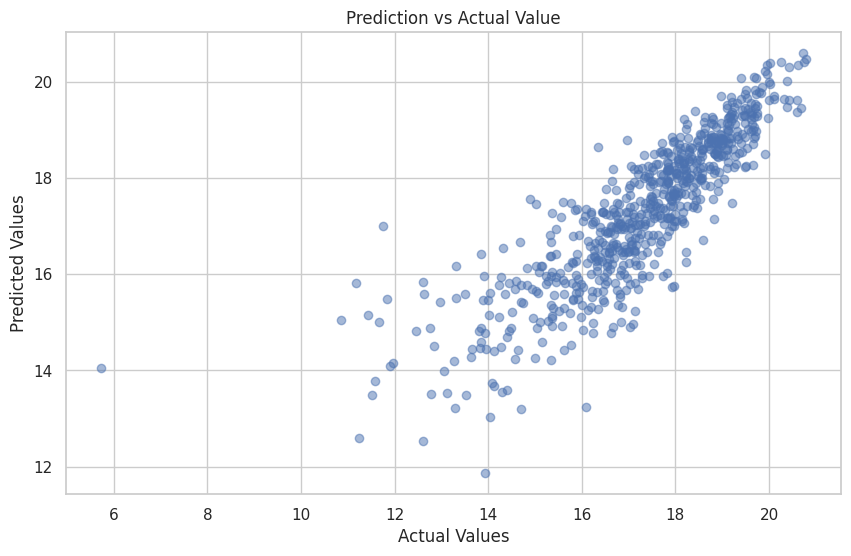

In [114]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Prediction vs Actual Value')
plt.show()